# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

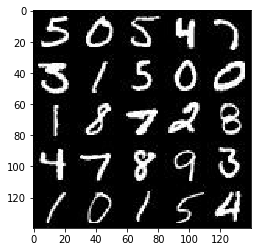

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

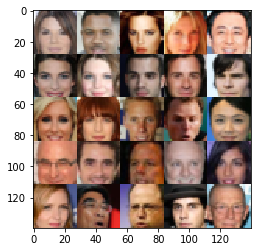

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ubuntu/miniconda3/envs/dlnd/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28x28x3
        x1 = tf.layers.conv2d(images, 32, 5, 2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        
        # 14x14x32
        x2 = tf.layers.conv2d(x1, 64, 5, 2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 7x7x64
        x3 = tf.layers.conv2d(x2, 128, 5, 2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        # 4x4x128
        x4 = tf.layers.conv2d(x3, 256, 5, 2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=True)
        x4 = tf.maximum(alpha * x4, x4)
        
        flat = tf.reshape(x4, (-1, 4*4*128))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
    
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    stddev = 0.02
    
    with tf.variable_scope('generator', reuse=not is_train):
        # 4x4x512
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        # 8x8x128
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, 1, padding='valid', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 16x16x64
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # 32x32x3
        x4 = tf.layers.conv2d_transpose(x3, 32, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3, 1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.tanh(logits)
    
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
#     d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
#                                                                          labels=tf.ones_like(d_model_real)))

    # try label smoothing
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real)*(1 - 0.1)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_e = 10
    show_e = 100
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # The value range of the MNIST/CelebA dataset:-0.5 to 0.5. tanh output -1 to 1.
                batch_images *= 2

                # normaliz input images
                sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: sample_z, 
                                                     lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: sample_z,
                                                     lr: learning_rate})
                
                if steps % print_e == 0:
                    train_loss_d = d_loss.eval({input_z: sample_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: sample_z})
                    
                    print("Epoch {}/{}:\t".format(epoch_i+1, epoch_count),
                          "Discriminator loss: {:.3f}\t".format(train_loss_d),
                          "Generator loss: {:.3f}".format(train_loss_g))
                if steps % show_e == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2:	 Discriminator loss: 5.140	 Generator loss: 0.010
Epoch 1/2:	 Discriminator loss: 1.834	 Generator loss: 0.373
Epoch 1/2:	 Discriminator loss: 1.739	 Generator loss: 0.367
Epoch 1/2:	 Discriminator loss: 1.351	 Generator loss: 0.943
Epoch 1/2:	 Discriminator loss: 2.370	 Generator loss: 0.165
Epoch 1/2:	 Discriminator loss: 1.986	 Generator loss: 0.262
Epoch 1/2:	 Discriminator loss: 1.914	 Generator loss: 0.266
Epoch 1/2:	 Discriminator loss: 1.523	 Generator loss: 1.555
Epoch 1/2:	 Discriminator loss: 2.276	 Generator loss: 0.165
Epoch 1/2:	 Discriminator loss: 1.252	 Generator loss: 0.743


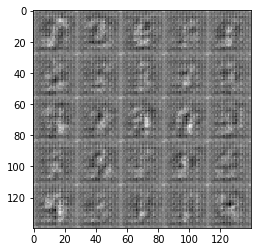

Epoch 1/2:	 Discriminator loss: 1.292	 Generator loss: 0.653
Epoch 1/2:	 Discriminator loss: 1.237	 Generator loss: 0.727
Epoch 1/2:	 Discriminator loss: 1.811	 Generator loss: 0.317
Epoch 1/2:	 Discriminator loss: 1.198	 Generator loss: 0.752
Epoch 1/2:	 Discriminator loss: 1.224	 Generator loss: 0.813
Epoch 1/2:	 Discriminator loss: 1.336	 Generator loss: 0.617
Epoch 1/2:	 Discriminator loss: 1.339	 Generator loss: 0.544
Epoch 1/2:	 Discriminator loss: 2.084	 Generator loss: 0.201
Epoch 1/2:	 Discriminator loss: 1.265	 Generator loss: 0.942
Epoch 1/2:	 Discriminator loss: 1.647	 Generator loss: 0.364


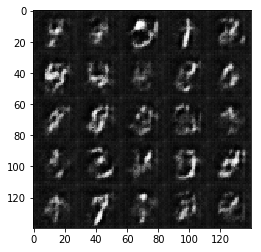

Epoch 1/2:	 Discriminator loss: 1.534	 Generator loss: 0.455
Epoch 1/2:	 Discriminator loss: 1.574	 Generator loss: 0.440
Epoch 1/2:	 Discriminator loss: 1.014	 Generator loss: 1.310
Epoch 1/2:	 Discriminator loss: 1.156	 Generator loss: 0.790
Epoch 1/2:	 Discriminator loss: 1.550	 Generator loss: 1.568
Epoch 1/2:	 Discriminator loss: 1.311	 Generator loss: 0.531
Epoch 1/2:	 Discriminator loss: 1.355	 Generator loss: 1.959
Epoch 1/2:	 Discriminator loss: 1.291	 Generator loss: 1.601
Epoch 1/2:	 Discriminator loss: 1.048	 Generator loss: 1.164
Epoch 1/2:	 Discriminator loss: 1.020	 Generator loss: 1.578


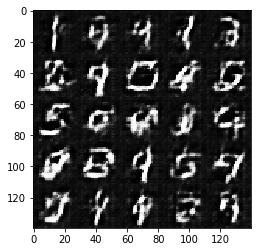

Epoch 1/2:	 Discriminator loss: 1.717	 Generator loss: 0.359
Epoch 1/2:	 Discriminator loss: 1.118	 Generator loss: 0.739
Epoch 1/2:	 Discriminator loss: 0.997	 Generator loss: 1.199
Epoch 1/2:	 Discriminator loss: 1.122	 Generator loss: 1.567
Epoch 1/2:	 Discriminator loss: 1.284	 Generator loss: 0.659
Epoch 1/2:	 Discriminator loss: 1.247	 Generator loss: 1.227
Epoch 1/2:	 Discriminator loss: 1.185	 Generator loss: 1.442
Epoch 1/2:	 Discriminator loss: 1.265	 Generator loss: 2.443
Epoch 1/2:	 Discriminator loss: 1.097	 Generator loss: 1.138
Epoch 1/2:	 Discriminator loss: 1.071	 Generator loss: 1.512


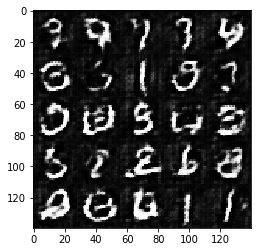

Epoch 1/2:	 Discriminator loss: 1.771	 Generator loss: 0.294
Epoch 1/2:	 Discriminator loss: 2.229	 Generator loss: 0.190
Epoch 1/2:	 Discriminator loss: 1.348	 Generator loss: 0.577
Epoch 1/2:	 Discriminator loss: 1.197	 Generator loss: 1.106
Epoch 1/2:	 Discriminator loss: 1.114	 Generator loss: 1.614
Epoch 1/2:	 Discriminator loss: 1.085	 Generator loss: 0.868
Epoch 1/2:	 Discriminator loss: 1.193	 Generator loss: 1.335
Epoch 1/2:	 Discriminator loss: 1.259	 Generator loss: 0.584
Epoch 1/2:	 Discriminator loss: 1.471	 Generator loss: 2.515
Epoch 1/2:	 Discriminator loss: 2.472	 Generator loss: 0.140


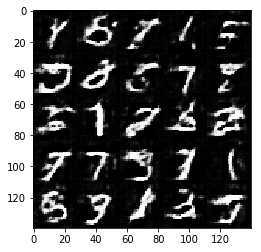

Epoch 1/2:	 Discriminator loss: 1.216	 Generator loss: 2.171
Epoch 1/2:	 Discriminator loss: 1.213	 Generator loss: 0.672
Epoch 1/2:	 Discriminator loss: 2.264	 Generator loss: 0.196
Epoch 1/2:	 Discriminator loss: 1.504	 Generator loss: 0.407
Epoch 1/2:	 Discriminator loss: 1.072	 Generator loss: 0.828
Epoch 1/2:	 Discriminator loss: 1.387	 Generator loss: 0.489
Epoch 1/2:	 Discriminator loss: 1.067	 Generator loss: 0.904
Epoch 1/2:	 Discriminator loss: 1.108	 Generator loss: 0.841
Epoch 1/2:	 Discriminator loss: 1.580	 Generator loss: 0.377
Epoch 1/2:	 Discriminator loss: 1.323	 Generator loss: 0.504


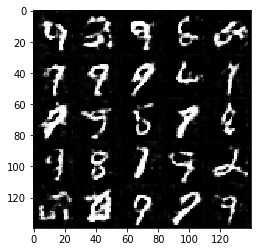

Epoch 1/2:	 Discriminator loss: 1.411	 Generator loss: 0.492
Epoch 1/2:	 Discriminator loss: 1.150	 Generator loss: 0.643
Epoch 1/2:	 Discriminator loss: 1.060	 Generator loss: 0.770
Epoch 1/2:	 Discriminator loss: 1.816	 Generator loss: 0.277
Epoch 1/2:	 Discriminator loss: 1.057	 Generator loss: 0.790
Epoch 1/2:	 Discriminator loss: 1.112	 Generator loss: 0.778
Epoch 1/2:	 Discriminator loss: 1.682	 Generator loss: 0.346
Epoch 1/2:	 Discriminator loss: 1.033	 Generator loss: 0.851
Epoch 1/2:	 Discriminator loss: 1.849	 Generator loss: 0.287
Epoch 1/2:	 Discriminator loss: 1.000	 Generator loss: 1.444


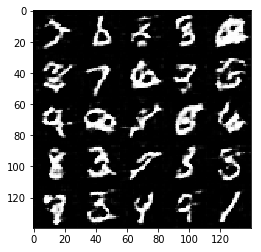

Epoch 1/2:	 Discriminator loss: 2.001	 Generator loss: 0.242
Epoch 1/2:	 Discriminator loss: 1.593	 Generator loss: 0.391
Epoch 1/2:	 Discriminator loss: 1.289	 Generator loss: 0.565
Epoch 1/2:	 Discriminator loss: 0.956	 Generator loss: 2.103
Epoch 1/2:	 Discriminator loss: 1.112	 Generator loss: 0.714
Epoch 1/2:	 Discriminator loss: 1.008	 Generator loss: 0.871
Epoch 1/2:	 Discriminator loss: 1.158	 Generator loss: 0.619
Epoch 1/2:	 Discriminator loss: 1.215	 Generator loss: 0.612
Epoch 1/2:	 Discriminator loss: 1.990	 Generator loss: 0.260
Epoch 1/2:	 Discriminator loss: 1.034	 Generator loss: 1.368


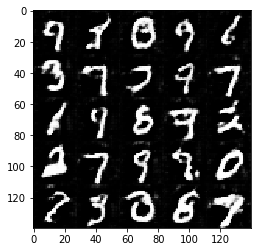

Epoch 1/2:	 Discriminator loss: 1.776	 Generator loss: 0.305
Epoch 1/2:	 Discriminator loss: 1.508	 Generator loss: 0.450
Epoch 1/2:	 Discriminator loss: 2.005	 Generator loss: 0.248
Epoch 1/2:	 Discriminator loss: 1.302	 Generator loss: 0.559
Epoch 1/2:	 Discriminator loss: 1.256	 Generator loss: 0.539
Epoch 1/2:	 Discriminator loss: 0.905	 Generator loss: 1.512
Epoch 1/2:	 Discriminator loss: 2.279	 Generator loss: 0.186
Epoch 1/2:	 Discriminator loss: 0.864	 Generator loss: 1.551
Epoch 1/2:	 Discriminator loss: 1.077	 Generator loss: 0.769
Epoch 1/2:	 Discriminator loss: 0.904	 Generator loss: 1.084


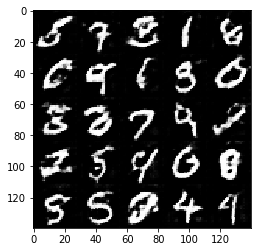

Epoch 1/2:	 Discriminator loss: 1.992	 Generator loss: 0.281
Epoch 1/2:	 Discriminator loss: 1.295	 Generator loss: 0.541
Epoch 1/2:	 Discriminator loss: 1.495	 Generator loss: 0.475
Epoch 1/2:	 Discriminator loss: 0.822	 Generator loss: 1.441
Epoch 1/2:	 Discriminator loss: 0.984	 Generator loss: 0.835
Epoch 1/2:	 Discriminator loss: 1.028	 Generator loss: 0.819
Epoch 1/2:	 Discriminator loss: 1.260	 Generator loss: 0.580
Epoch 1/2:	 Discriminator loss: 1.979	 Generator loss: 0.285
Epoch 1/2:	 Discriminator loss: 1.031	 Generator loss: 0.863
Epoch 1/2:	 Discriminator loss: 0.954	 Generator loss: 1.902


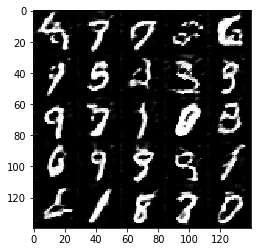

Epoch 1/2:	 Discriminator loss: 0.861	 Generator loss: 1.366
Epoch 1/2:	 Discriminator loss: 1.114	 Generator loss: 1.194
Epoch 1/2:	 Discriminator loss: 0.991	 Generator loss: 0.816
Epoch 1/2:	 Discriminator loss: 1.060	 Generator loss: 0.776
Epoch 1/2:	 Discriminator loss: 1.714	 Generator loss: 0.339
Epoch 1/2:	 Discriminator loss: 0.941	 Generator loss: 1.039
Epoch 1/2:	 Discriminator loss: 2.076	 Generator loss: 0.229
Epoch 1/2:	 Discriminator loss: 0.907	 Generator loss: 1.053
Epoch 1/2:	 Discriminator loss: 1.187	 Generator loss: 1.161
Epoch 1/2:	 Discriminator loss: 0.848	 Generator loss: 1.369


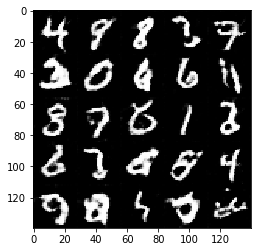

Epoch 1/2:	 Discriminator loss: 1.608	 Generator loss: 0.444
Epoch 1/2:	 Discriminator loss: 0.896	 Generator loss: 1.528
Epoch 1/2:	 Discriminator loss: 1.755	 Generator loss: 0.320
Epoch 1/2:	 Discriminator loss: 1.017	 Generator loss: 1.728
Epoch 1/2:	 Discriminator loss: 1.086	 Generator loss: 0.762
Epoch 1/2:	 Discriminator loss: 0.796	 Generator loss: 1.295
Epoch 1/2:	 Discriminator loss: 1.033	 Generator loss: 0.857
Epoch 1/2:	 Discriminator loss: 1.503	 Generator loss: 0.413
Epoch 1/2:	 Discriminator loss: 1.958	 Generator loss: 0.248
Epoch 1/2:	 Discriminator loss: 1.829	 Generator loss: 0.288


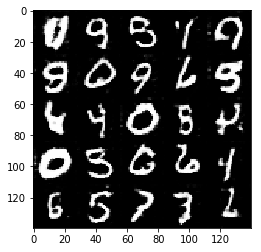

Epoch 1/2:	 Discriminator loss: 2.090	 Generator loss: 0.228
Epoch 1/2:	 Discriminator loss: 1.126	 Generator loss: 0.675
Epoch 1/2:	 Discriminator loss: 0.836	 Generator loss: 1.677
Epoch 1/2:	 Discriminator loss: 1.169	 Generator loss: 1.039
Epoch 1/2:	 Discriminator loss: 0.901	 Generator loss: 1.829
Epoch 1/2:	 Discriminator loss: 0.878	 Generator loss: 1.083
Epoch 1/2:	 Discriminator loss: 0.845	 Generator loss: 1.299
Epoch 1/2:	 Discriminator loss: 1.350	 Generator loss: 0.511
Epoch 1/2:	 Discriminator loss: 1.418	 Generator loss: 0.502
Epoch 1/2:	 Discriminator loss: 1.082	 Generator loss: 0.766


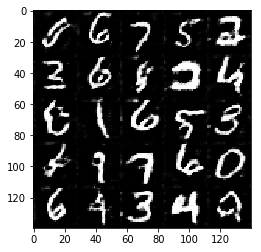

Epoch 1/2:	 Discriminator loss: 1.202	 Generator loss: 1.962
Epoch 1/2:	 Discriminator loss: 1.830	 Generator loss: 0.288
Epoch 1/2:	 Discriminator loss: 1.079	 Generator loss: 1.263
Epoch 1/2:	 Discriminator loss: 1.406	 Generator loss: 0.461
Epoch 1/2:	 Discriminator loss: 1.039	 Generator loss: 1.262
Epoch 1/2:	 Discriminator loss: 2.023	 Generator loss: 0.229
Epoch 1/2:	 Discriminator loss: 1.231	 Generator loss: 0.617
Epoch 1/2:	 Discriminator loss: 1.135	 Generator loss: 0.727
Epoch 1/2:	 Discriminator loss: 1.196	 Generator loss: 0.611
Epoch 1/2:	 Discriminator loss: 0.910	 Generator loss: 1.001


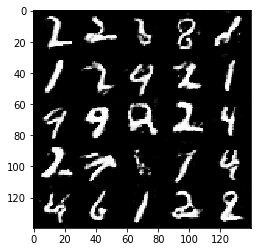

Epoch 1/2:	 Discriminator loss: 1.423	 Generator loss: 0.463
Epoch 1/2:	 Discriminator loss: 0.953	 Generator loss: 0.937
Epoch 1/2:	 Discriminator loss: 1.340	 Generator loss: 0.486
Epoch 1/2:	 Discriminator loss: 0.877	 Generator loss: 0.997
Epoch 1/2:	 Discriminator loss: 1.177	 Generator loss: 0.633
Epoch 1/2:	 Discriminator loss: 1.043	 Generator loss: 0.762
Epoch 1/2:	 Discriminator loss: 1.151	 Generator loss: 0.727
Epoch 1/2:	 Discriminator loss: 1.001	 Generator loss: 1.224
Epoch 1/2:	 Discriminator loss: 0.811	 Generator loss: 1.748
Epoch 1/2:	 Discriminator loss: 1.140	 Generator loss: 0.650


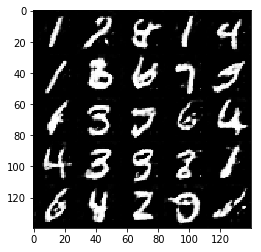

Epoch 1/2:	 Discriminator loss: 1.188	 Generator loss: 1.089
Epoch 1/2:	 Discriminator loss: 0.985	 Generator loss: 1.683
Epoch 1/2:	 Discriminator loss: 1.481	 Generator loss: 0.411
Epoch 1/2:	 Discriminator loss: 1.949	 Generator loss: 0.277
Epoch 1/2:	 Discriminator loss: 1.929	 Generator loss: 0.287
Epoch 1/2:	 Discriminator loss: 1.985	 Generator loss: 0.237
Epoch 1/2:	 Discriminator loss: 1.322	 Generator loss: 0.567
Epoch 1/2:	 Discriminator loss: 1.983	 Generator loss: 0.245
Epoch 1/2:	 Discriminator loss: 1.180	 Generator loss: 0.605
Epoch 1/2:	 Discriminator loss: 1.318	 Generator loss: 0.541


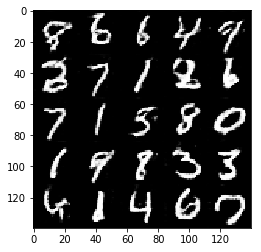

Epoch 1/2:	 Discriminator loss: 1.528	 Generator loss: 0.396
Epoch 1/2:	 Discriminator loss: 1.665	 Generator loss: 0.342
Epoch 1/2:	 Discriminator loss: 1.157	 Generator loss: 0.676
Epoch 1/2:	 Discriminator loss: 0.900	 Generator loss: 1.005
Epoch 1/2:	 Discriminator loss: 1.601	 Generator loss: 0.367
Epoch 1/2:	 Discriminator loss: 1.514	 Generator loss: 0.395
Epoch 1/2:	 Discriminator loss: 1.237	 Generator loss: 0.591
Epoch 1/2:	 Discriminator loss: 1.053	 Generator loss: 2.014
Epoch 1/2:	 Discriminator loss: 1.541	 Generator loss: 0.389
Epoch 1/2:	 Discriminator loss: 1.450	 Generator loss: 0.448


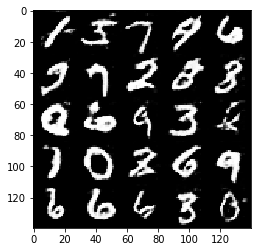

Epoch 1/2:	 Discriminator loss: 0.926	 Generator loss: 1.187
Epoch 1/2:	 Discriminator loss: 1.715	 Generator loss: 0.396
Epoch 1/2:	 Discriminator loss: 1.083	 Generator loss: 0.739
Epoch 1/2:	 Discriminator loss: 1.707	 Generator loss: 0.319
Epoch 1/2:	 Discriminator loss: 1.325	 Generator loss: 1.962
Epoch 1/2:	 Discriminator loss: 1.267	 Generator loss: 0.553
Epoch 1/2:	 Discriminator loss: 0.960	 Generator loss: 1.789
Epoch 1/2:	 Discriminator loss: 1.129	 Generator loss: 0.712
Epoch 1/2:	 Discriminator loss: 0.990	 Generator loss: 1.098
Epoch 1/2:	 Discriminator loss: 1.037	 Generator loss: 0.762


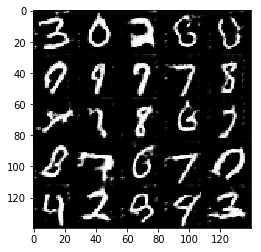

Epoch 1/2:	 Discriminator loss: 1.142	 Generator loss: 0.758
Epoch 1/2:	 Discriminator loss: 1.202	 Generator loss: 0.577
Epoch 1/2:	 Discriminator loss: 2.090	 Generator loss: 0.225
Epoch 1/2:	 Discriminator loss: 1.071	 Generator loss: 0.687
Epoch 1/2:	 Discriminator loss: 0.883	 Generator loss: 1.099
Epoch 1/2:	 Discriminator loss: 1.578	 Generator loss: 0.373
Epoch 1/2:	 Discriminator loss: 1.863	 Generator loss: 0.281
Epoch 2/2:	 Discriminator loss: 1.945	 Generator loss: 0.255
Epoch 2/2:	 Discriminator loss: 1.091	 Generator loss: 0.797
Epoch 2/2:	 Discriminator loss: 1.271	 Generator loss: 0.536


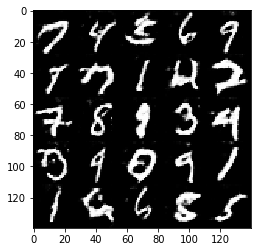

Epoch 2/2:	 Discriminator loss: 1.802	 Generator loss: 0.325
Epoch 2/2:	 Discriminator loss: 1.114	 Generator loss: 1.850
Epoch 2/2:	 Discriminator loss: 0.758	 Generator loss: 1.125
Epoch 2/2:	 Discriminator loss: 1.736	 Generator loss: 0.331
Epoch 2/2:	 Discriminator loss: 1.653	 Generator loss: 0.351
Epoch 2/2:	 Discriminator loss: 0.693	 Generator loss: 1.831
Epoch 2/2:	 Discriminator loss: 0.739	 Generator loss: 1.469
Epoch 2/2:	 Discriminator loss: 0.908	 Generator loss: 1.354
Epoch 2/2:	 Discriminator loss: 0.799	 Generator loss: 1.641
Epoch 2/2:	 Discriminator loss: 1.453	 Generator loss: 0.425


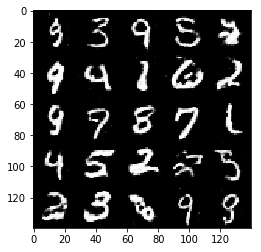

Epoch 2/2:	 Discriminator loss: 1.166	 Generator loss: 0.633
Epoch 2/2:	 Discriminator loss: 0.845	 Generator loss: 1.116
Epoch 2/2:	 Discriminator loss: 1.937	 Generator loss: 0.280
Epoch 2/2:	 Discriminator loss: 0.822	 Generator loss: 1.025
Epoch 2/2:	 Discriminator loss: 0.880	 Generator loss: 1.673
Epoch 2/2:	 Discriminator loss: 0.816	 Generator loss: 1.156
Epoch 2/2:	 Discriminator loss: 0.881	 Generator loss: 1.023
Epoch 2/2:	 Discriminator loss: 0.787	 Generator loss: 1.166
Epoch 2/2:	 Discriminator loss: 0.791	 Generator loss: 1.073
Epoch 2/2:	 Discriminator loss: 1.655	 Generator loss: 0.399


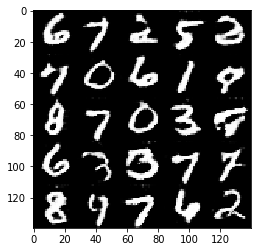

Epoch 2/2:	 Discriminator loss: 2.060	 Generator loss: 0.238
Epoch 2/2:	 Discriminator loss: 0.659	 Generator loss: 1.716
Epoch 2/2:	 Discriminator loss: 1.034	 Generator loss: 0.812
Epoch 2/2:	 Discriminator loss: 0.872	 Generator loss: 1.369
Epoch 2/2:	 Discriminator loss: 1.062	 Generator loss: 0.774
Epoch 2/2:	 Discriminator loss: 1.371	 Generator loss: 0.470
Epoch 2/2:	 Discriminator loss: 0.888	 Generator loss: 1.147
Epoch 2/2:	 Discriminator loss: 1.957	 Generator loss: 0.310
Epoch 2/2:	 Discriminator loss: 1.220	 Generator loss: 0.574
Epoch 2/2:	 Discriminator loss: 0.862	 Generator loss: 1.862


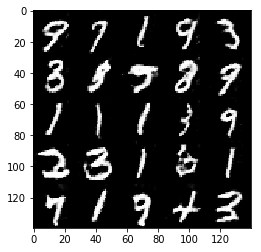

Epoch 2/2:	 Discriminator loss: 1.706	 Generator loss: 0.419
Epoch 2/2:	 Discriminator loss: 1.039	 Generator loss: 1.565
Epoch 2/2:	 Discriminator loss: 0.820	 Generator loss: 1.028
Epoch 2/2:	 Discriminator loss: 1.388	 Generator loss: 0.488
Epoch 2/2:	 Discriminator loss: 0.897	 Generator loss: 0.938
Epoch 2/2:	 Discriminator loss: 1.478	 Generator loss: 0.433
Epoch 2/2:	 Discriminator loss: 0.866	 Generator loss: 0.972
Epoch 2/2:	 Discriminator loss: 0.884	 Generator loss: 1.157
Epoch 2/2:	 Discriminator loss: 1.344	 Generator loss: 0.495
Epoch 2/2:	 Discriminator loss: 2.324	 Generator loss: 0.211


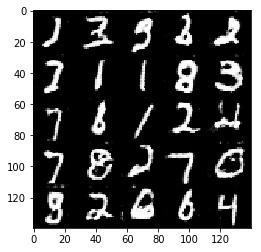

Epoch 2/2:	 Discriminator loss: 1.295	 Generator loss: 0.588
Epoch 2/2:	 Discriminator loss: 1.381	 Generator loss: 0.481
Epoch 2/2:	 Discriminator loss: 1.240	 Generator loss: 1.399
Epoch 2/2:	 Discriminator loss: 1.125	 Generator loss: 0.660
Epoch 2/2:	 Discriminator loss: 0.805	 Generator loss: 1.102
Epoch 2/2:	 Discriminator loss: 1.075	 Generator loss: 0.718
Epoch 2/2:	 Discriminator loss: 0.880	 Generator loss: 0.995
Epoch 2/2:	 Discriminator loss: 1.016	 Generator loss: 2.380
Epoch 2/2:	 Discriminator loss: 0.754	 Generator loss: 1.661
Epoch 2/2:	 Discriminator loss: 0.953	 Generator loss: 2.404


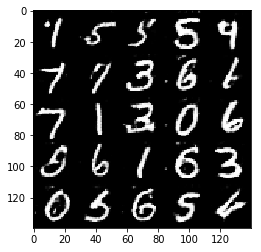

Epoch 2/2:	 Discriminator loss: 1.385	 Generator loss: 0.485
Epoch 2/2:	 Discriminator loss: 0.744	 Generator loss: 1.768
Epoch 2/2:	 Discriminator loss: 2.366	 Generator loss: 0.220
Epoch 2/2:	 Discriminator loss: 1.621	 Generator loss: 0.396
Epoch 2/2:	 Discriminator loss: 1.597	 Generator loss: 0.355
Epoch 2/2:	 Discriminator loss: 1.150	 Generator loss: 0.688
Epoch 2/2:	 Discriminator loss: 1.663	 Generator loss: 0.389
Epoch 2/2:	 Discriminator loss: 1.071	 Generator loss: 0.746
Epoch 2/2:	 Discriminator loss: 1.036	 Generator loss: 0.808
Epoch 2/2:	 Discriminator loss: 0.778	 Generator loss: 1.389


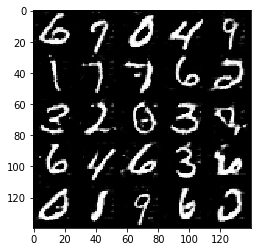

Epoch 2/2:	 Discriminator loss: 1.207	 Generator loss: 0.614
Epoch 2/2:	 Discriminator loss: 1.742	 Generator loss: 0.436
Epoch 2/2:	 Discriminator loss: 1.436	 Generator loss: 0.458
Epoch 2/2:	 Discriminator loss: 1.466	 Generator loss: 0.461
Epoch 2/2:	 Discriminator loss: 1.064	 Generator loss: 0.710
Epoch 2/2:	 Discriminator loss: 1.011	 Generator loss: 0.807
Epoch 2/2:	 Discriminator loss: 1.466	 Generator loss: 3.286
Epoch 2/2:	 Discriminator loss: 0.965	 Generator loss: 0.873
Epoch 2/2:	 Discriminator loss: 1.856	 Generator loss: 4.544
Epoch 2/2:	 Discriminator loss: 0.933	 Generator loss: 1.046


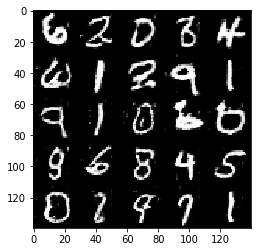

Epoch 2/2:	 Discriminator loss: 1.293	 Generator loss: 0.541
Epoch 2/2:	 Discriminator loss: 1.219	 Generator loss: 0.654
Epoch 2/2:	 Discriminator loss: 0.865	 Generator loss: 1.057
Epoch 2/2:	 Discriminator loss: 2.203	 Generator loss: 0.287
Epoch 2/2:	 Discriminator loss: 0.875	 Generator loss: 1.074
Epoch 2/2:	 Discriminator loss: 2.724	 Generator loss: 0.147
Epoch 2/2:	 Discriminator loss: 1.077	 Generator loss: 0.842
Epoch 2/2:	 Discriminator loss: 0.892	 Generator loss: 0.967
Epoch 2/2:	 Discriminator loss: 1.599	 Generator loss: 0.407
Epoch 2/2:	 Discriminator loss: 1.698	 Generator loss: 0.404


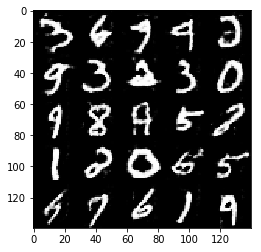

Epoch 2/2:	 Discriminator loss: 0.971	 Generator loss: 2.173
Epoch 2/2:	 Discriminator loss: 0.628	 Generator loss: 1.626
Epoch 2/2:	 Discriminator loss: 2.366	 Generator loss: 0.194
Epoch 2/2:	 Discriminator loss: 1.048	 Generator loss: 1.318
Epoch 2/2:	 Discriminator loss: 1.111	 Generator loss: 0.689
Epoch 2/2:	 Discriminator loss: 0.823	 Generator loss: 1.034
Epoch 2/2:	 Discriminator loss: 0.766	 Generator loss: 1.375
Epoch 2/2:	 Discriminator loss: 2.274	 Generator loss: 0.258
Epoch 2/2:	 Discriminator loss: 0.799	 Generator loss: 1.649
Epoch 2/2:	 Discriminator loss: 1.461	 Generator loss: 0.464


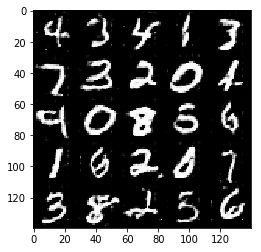

Epoch 2/2:	 Discriminator loss: 0.613	 Generator loss: 2.015
Epoch 2/2:	 Discriminator loss: 2.396	 Generator loss: 0.206
Epoch 2/2:	 Discriminator loss: 1.733	 Generator loss: 0.354
Epoch 2/2:	 Discriminator loss: 0.802	 Generator loss: 1.957
Epoch 2/2:	 Discriminator loss: 1.096	 Generator loss: 0.726
Epoch 2/2:	 Discriminator loss: 3.120	 Generator loss: 0.079
Epoch 2/2:	 Discriminator loss: 1.396	 Generator loss: 0.478
Epoch 2/2:	 Discriminator loss: 0.749	 Generator loss: 1.616
Epoch 2/2:	 Discriminator loss: 0.678	 Generator loss: 1.322
Epoch 2/2:	 Discriminator loss: 0.770	 Generator loss: 1.143


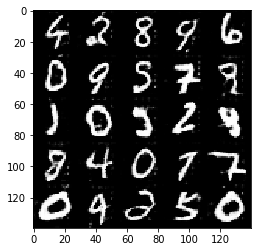

Epoch 2/2:	 Discriminator loss: 0.855	 Generator loss: 0.942
Epoch 2/2:	 Discriminator loss: 0.758	 Generator loss: 1.700
Epoch 2/2:	 Discriminator loss: 0.545	 Generator loss: 2.138
Epoch 2/2:	 Discriminator loss: 0.743	 Generator loss: 2.075
Epoch 2/2:	 Discriminator loss: 0.620	 Generator loss: 1.539
Epoch 2/2:	 Discriminator loss: 1.456	 Generator loss: 0.427
Epoch 2/2:	 Discriminator loss: 0.807	 Generator loss: 1.163
Epoch 2/2:	 Discriminator loss: 1.024	 Generator loss: 0.777
Epoch 2/2:	 Discriminator loss: 0.893	 Generator loss: 0.932
Epoch 2/2:	 Discriminator loss: 2.452	 Generator loss: 0.152


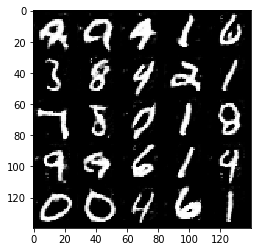

Epoch 2/2:	 Discriminator loss: 1.007	 Generator loss: 0.810
Epoch 2/2:	 Discriminator loss: 2.335	 Generator loss: 0.214
Epoch 2/2:	 Discriminator loss: 0.997	 Generator loss: 0.903
Epoch 2/2:	 Discriminator loss: 0.656	 Generator loss: 1.517
Epoch 2/2:	 Discriminator loss: 1.263	 Generator loss: 0.726
Epoch 2/2:	 Discriminator loss: 0.952	 Generator loss: 1.025
Epoch 2/2:	 Discriminator loss: 1.906	 Generator loss: 0.336
Epoch 2/2:	 Discriminator loss: 0.716	 Generator loss: 1.339
Epoch 2/2:	 Discriminator loss: 1.761	 Generator loss: 0.314
Epoch 2/2:	 Discriminator loss: 1.478	 Generator loss: 0.415


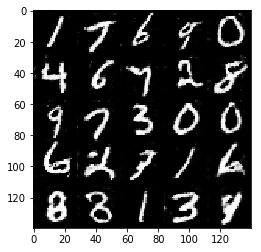

Epoch 2/2:	 Discriminator loss: 1.737	 Generator loss: 0.329
Epoch 2/2:	 Discriminator loss: 1.090	 Generator loss: 0.692
Epoch 2/2:	 Discriminator loss: 1.283	 Generator loss: 0.562
Epoch 2/2:	 Discriminator loss: 1.124	 Generator loss: 2.447
Epoch 2/2:	 Discriminator loss: 1.105	 Generator loss: 1.940
Epoch 2/2:	 Discriminator loss: 1.010	 Generator loss: 0.765
Epoch 2/2:	 Discriminator loss: 0.694	 Generator loss: 1.854
Epoch 2/2:	 Discriminator loss: 1.179	 Generator loss: 0.695
Epoch 2/2:	 Discriminator loss: 0.814	 Generator loss: 1.512
Epoch 2/2:	 Discriminator loss: 1.346	 Generator loss: 0.507


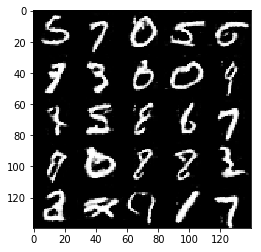

Epoch 2/2:	 Discriminator loss: 0.698	 Generator loss: 1.299
Epoch 2/2:	 Discriminator loss: 1.416	 Generator loss: 0.492
Epoch 2/2:	 Discriminator loss: 0.872	 Generator loss: 2.995
Epoch 2/2:	 Discriminator loss: 0.757	 Generator loss: 1.124
Epoch 2/2:	 Discriminator loss: 1.205	 Generator loss: 2.378
Epoch 2/2:	 Discriminator loss: 1.779	 Generator loss: 0.350
Epoch 2/2:	 Discriminator loss: 0.707	 Generator loss: 1.271
Epoch 2/2:	 Discriminator loss: 0.613	 Generator loss: 1.805
Epoch 2/2:	 Discriminator loss: 2.089	 Generator loss: 0.253
Epoch 2/2:	 Discriminator loss: 0.939	 Generator loss: 0.996


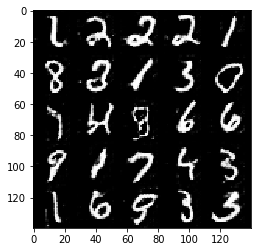

Epoch 2/2:	 Discriminator loss: 0.818	 Generator loss: 1.371
Epoch 2/2:	 Discriminator loss: 1.367	 Generator loss: 3.285
Epoch 2/2:	 Discriminator loss: 0.889	 Generator loss: 0.943
Epoch 2/2:	 Discriminator loss: 0.733	 Generator loss: 1.221
Epoch 2/2:	 Discriminator loss: 0.753	 Generator loss: 1.416
Epoch 2/2:	 Discriminator loss: 0.809	 Generator loss: 1.422
Epoch 2/2:	 Discriminator loss: 0.898	 Generator loss: 0.915
Epoch 2/2:	 Discriminator loss: 0.580	 Generator loss: 2.218
Epoch 2/2:	 Discriminator loss: 1.088	 Generator loss: 3.159
Epoch 2/2:	 Discriminator loss: 0.791	 Generator loss: 1.805


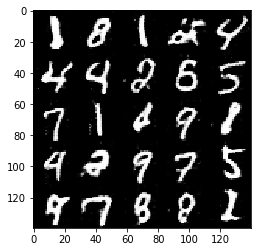

Epoch 2/2:	 Discriminator loss: 1.917	 Generator loss: 0.348
Epoch 2/2:	 Discriminator loss: 0.692	 Generator loss: 2.767
Epoch 2/2:	 Discriminator loss: 1.085	 Generator loss: 0.696
Epoch 2/2:	 Discriminator loss: 1.149	 Generator loss: 0.657
Epoch 2/2:	 Discriminator loss: 0.749	 Generator loss: 1.441
Epoch 2/2:	 Discriminator loss: 0.789	 Generator loss: 1.155
Epoch 2/2:	 Discriminator loss: 0.834	 Generator loss: 2.747
Epoch 2/2:	 Discriminator loss: 1.518	 Generator loss: 0.578
Epoch 2/2:	 Discriminator loss: 0.766	 Generator loss: 1.224
Epoch 2/2:	 Discriminator loss: 1.446	 Generator loss: 0.488


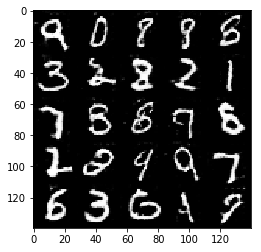

Epoch 2/2:	 Discriminator loss: 1.360	 Generator loss: 0.538
Epoch 2/2:	 Discriminator loss: 0.751	 Generator loss: 1.310
Epoch 2/2:	 Discriminator loss: 0.759	 Generator loss: 1.227
Epoch 2/2:	 Discriminator loss: 1.261	 Generator loss: 0.654
Epoch 2/2:	 Discriminator loss: 0.977	 Generator loss: 0.790
Epoch 2/2:	 Discriminator loss: 0.953	 Generator loss: 0.818
Epoch 2/2:	 Discriminator loss: 3.773	 Generator loss: 0.060
Epoch 2/2:	 Discriminator loss: 0.872	 Generator loss: 0.978
Epoch 2/2:	 Discriminator loss: 0.693	 Generator loss: 1.363
Epoch 2/2:	 Discriminator loss: 1.065	 Generator loss: 0.779


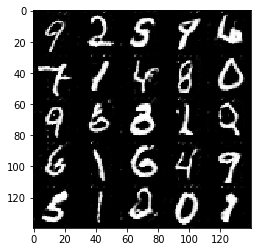

Epoch 2/2:	 Discriminator loss: 2.124	 Generator loss: 0.268
Epoch 2/2:	 Discriminator loss: 1.505	 Generator loss: 0.464
Epoch 2/2:	 Discriminator loss: 2.489	 Generator loss: 0.200
Epoch 2/2:	 Discriminator loss: 1.758	 Generator loss: 0.403
Epoch 2/2:	 Discriminator loss: 2.162	 Generator loss: 0.233
Epoch 2/2:	 Discriminator loss: 0.651	 Generator loss: 1.882
Epoch 2/2:	 Discriminator loss: 1.275	 Generator loss: 0.561
Epoch 2/2:	 Discriminator loss: 1.451	 Generator loss: 0.531
Epoch 2/2:	 Discriminator loss: 1.359	 Generator loss: 0.478
Epoch 2/2:	 Discriminator loss: 0.539	 Generator loss: 2.010


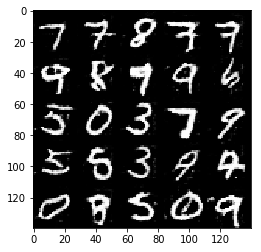

Epoch 2/2:	 Discriminator loss: 0.717	 Generator loss: 1.584
Epoch 2/2:	 Discriminator loss: 0.721	 Generator loss: 1.553
Epoch 2/2:	 Discriminator loss: 0.879	 Generator loss: 0.977
Epoch 2/2:	 Discriminator loss: 1.396	 Generator loss: 0.490
Epoch 2/2:	 Discriminator loss: 0.819	 Generator loss: 1.074


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1:	 Discriminator loss: 2.417	 Generator loss: 5.648
Epoch 1/1:	 Discriminator loss: 1.720	 Generator loss: 0.364
Epoch 1/1:	 Discriminator loss: 2.267	 Generator loss: 0.265
Epoch 1/1:	 Discriminator loss: 1.358	 Generator loss: 1.381
Epoch 1/1:	 Discriminator loss: 1.653	 Generator loss: 3.550
Epoch 1/1:	 Discriminator loss: 2.363	 Generator loss: 0.193
Epoch 1/1:	 Discriminator loss: 1.082	 Generator loss: 1.004
Epoch 1/1:	 Discriminator loss: 1.351	 Generator loss: 0.585
Epoch 1/1:	 Discriminator loss: 2.133	 Generator loss: 0.231
Epoch 1/1:	 Discriminator loss: 2.016	 Generator loss: 0.286


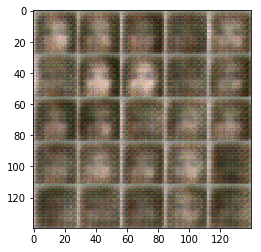

Epoch 1/1:	 Discriminator loss: 1.656	 Generator loss: 0.433
Epoch 1/1:	 Discriminator loss: 1.412	 Generator loss: 0.773
Epoch 1/1:	 Discriminator loss: 1.327	 Generator loss: 0.625
Epoch 1/1:	 Discriminator loss: 1.527	 Generator loss: 0.451
Epoch 1/1:	 Discriminator loss: 1.249	 Generator loss: 0.940
Epoch 1/1:	 Discriminator loss: 1.533	 Generator loss: 0.513
Epoch 1/1:	 Discriminator loss: 1.700	 Generator loss: 0.350
Epoch 1/1:	 Discriminator loss: 1.325	 Generator loss: 0.617
Epoch 1/1:	 Discriminator loss: 1.179	 Generator loss: 0.888
Epoch 1/1:	 Discriminator loss: 1.343	 Generator loss: 0.555


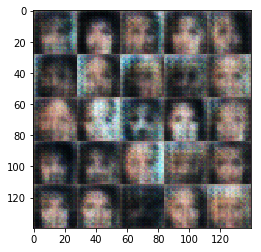

Epoch 1/1:	 Discriminator loss: 1.295	 Generator loss: 0.979
Epoch 1/1:	 Discriminator loss: 1.455	 Generator loss: 0.534
Epoch 1/1:	 Discriminator loss: 1.510	 Generator loss: 0.626
Epoch 1/1:	 Discriminator loss: 1.428	 Generator loss: 0.780
Epoch 1/1:	 Discriminator loss: 1.580	 Generator loss: 0.428
Epoch 1/1:	 Discriminator loss: 1.605	 Generator loss: 0.397
Epoch 1/1:	 Discriminator loss: 1.543	 Generator loss: 0.405
Epoch 1/1:	 Discriminator loss: 1.180	 Generator loss: 0.873
Epoch 1/1:	 Discriminator loss: 1.271	 Generator loss: 0.748
Epoch 1/1:	 Discriminator loss: 1.366	 Generator loss: 1.075


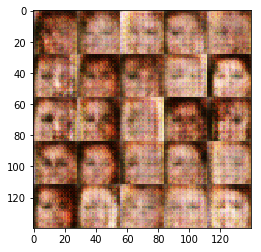

Epoch 1/1:	 Discriminator loss: 1.322	 Generator loss: 0.684
Epoch 1/1:	 Discriminator loss: 1.232	 Generator loss: 0.768
Epoch 1/1:	 Discriminator loss: 1.340	 Generator loss: 0.680
Epoch 1/1:	 Discriminator loss: 1.362	 Generator loss: 0.645
Epoch 1/1:	 Discriminator loss: 1.199	 Generator loss: 0.861
Epoch 1/1:	 Discriminator loss: 1.327	 Generator loss: 0.550
Epoch 1/1:	 Discriminator loss: 1.281	 Generator loss: 0.661
Epoch 1/1:	 Discriminator loss: 1.180	 Generator loss: 0.960
Epoch 1/1:	 Discriminator loss: 1.541	 Generator loss: 0.551
Epoch 1/1:	 Discriminator loss: 1.117	 Generator loss: 0.943


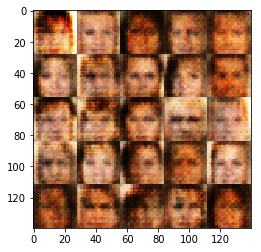

Epoch 1/1:	 Discriminator loss: 1.473	 Generator loss: 0.419
Epoch 1/1:	 Discriminator loss: 1.459	 Generator loss: 0.542
Epoch 1/1:	 Discriminator loss: 1.445	 Generator loss: 0.607
Epoch 1/1:	 Discriminator loss: 1.507	 Generator loss: 0.434
Epoch 1/1:	 Discriminator loss: 1.358	 Generator loss: 0.691
Epoch 1/1:	 Discriminator loss: 1.408	 Generator loss: 0.581
Epoch 1/1:	 Discriminator loss: 1.781	 Generator loss: 0.287
Epoch 1/1:	 Discriminator loss: 1.204	 Generator loss: 0.940
Epoch 1/1:	 Discriminator loss: 1.345	 Generator loss: 0.621
Epoch 1/1:	 Discriminator loss: 1.251	 Generator loss: 0.813


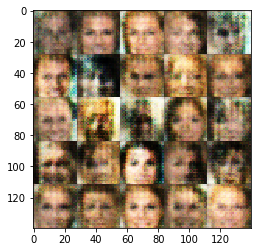

Epoch 1/1:	 Discriminator loss: 1.224	 Generator loss: 0.798
Epoch 1/1:	 Discriminator loss: 1.423	 Generator loss: 0.560
Epoch 1/1:	 Discriminator loss: 1.429	 Generator loss: 0.581
Epoch 1/1:	 Discriminator loss: 1.351	 Generator loss: 0.795
Epoch 1/1:	 Discriminator loss: 1.271	 Generator loss: 0.874
Epoch 1/1:	 Discriminator loss: 1.455	 Generator loss: 0.545
Epoch 1/1:	 Discriminator loss: 1.240	 Generator loss: 0.806
Epoch 1/1:	 Discriminator loss: 1.330	 Generator loss: 0.672
Epoch 1/1:	 Discriminator loss: 1.468	 Generator loss: 0.462
Epoch 1/1:	 Discriminator loss: 1.290	 Generator loss: 0.799


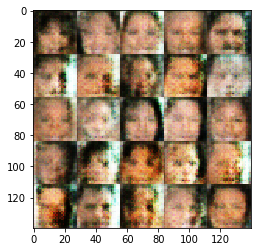

Epoch 1/1:	 Discriminator loss: 1.368	 Generator loss: 0.603
Epoch 1/1:	 Discriminator loss: 1.493	 Generator loss: 0.442
Epoch 1/1:	 Discriminator loss: 1.393	 Generator loss: 0.487
Epoch 1/1:	 Discriminator loss: 1.346	 Generator loss: 0.742
Epoch 1/1:	 Discriminator loss: 1.300	 Generator loss: 0.992
Epoch 1/1:	 Discriminator loss: 1.414	 Generator loss: 0.999
Epoch 1/1:	 Discriminator loss: 1.444	 Generator loss: 0.490
Epoch 1/1:	 Discriminator loss: 1.604	 Generator loss: 0.437
Epoch 1/1:	 Discriminator loss: 1.399	 Generator loss: 0.603
Epoch 1/1:	 Discriminator loss: 1.208	 Generator loss: 0.846


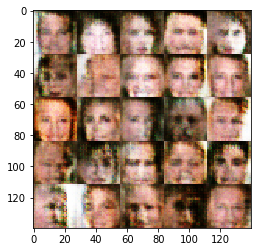

Epoch 1/1:	 Discriminator loss: 1.384	 Generator loss: 0.693
Epoch 1/1:	 Discriminator loss: 1.202	 Generator loss: 0.866
Epoch 1/1:	 Discriminator loss: 1.198	 Generator loss: 0.874
Epoch 1/1:	 Discriminator loss: 1.352	 Generator loss: 0.714
Epoch 1/1:	 Discriminator loss: 1.357	 Generator loss: 0.826
Epoch 1/1:	 Discriminator loss: 1.413	 Generator loss: 0.640
Epoch 1/1:	 Discriminator loss: 1.369	 Generator loss: 0.609
Epoch 1/1:	 Discriminator loss: 1.554	 Generator loss: 0.443
Epoch 1/1:	 Discriminator loss: 1.396	 Generator loss: 0.563
Epoch 1/1:	 Discriminator loss: 1.234	 Generator loss: 0.958


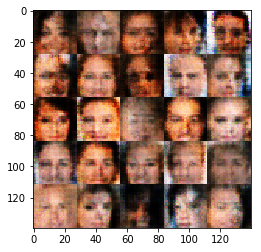

Epoch 1/1:	 Discriminator loss: 1.730	 Generator loss: 0.340
Epoch 1/1:	 Discriminator loss: 1.296	 Generator loss: 0.948
Epoch 1/1:	 Discriminator loss: 1.256	 Generator loss: 0.696
Epoch 1/1:	 Discriminator loss: 1.370	 Generator loss: 0.691
Epoch 1/1:	 Discriminator loss: 1.458	 Generator loss: 0.736
Epoch 1/1:	 Discriminator loss: 1.391	 Generator loss: 0.758
Epoch 1/1:	 Discriminator loss: 1.270	 Generator loss: 0.774
Epoch 1/1:	 Discriminator loss: 1.325	 Generator loss: 0.924
Epoch 1/1:	 Discriminator loss: 1.130	 Generator loss: 0.884
Epoch 1/1:	 Discriminator loss: 1.400	 Generator loss: 0.766


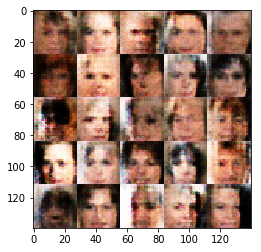

Epoch 1/1:	 Discriminator loss: 1.542	 Generator loss: 0.429
Epoch 1/1:	 Discriminator loss: 1.436	 Generator loss: 0.503
Epoch 1/1:	 Discriminator loss: 1.456	 Generator loss: 1.342
Epoch 1/1:	 Discriminator loss: 1.536	 Generator loss: 0.508
Epoch 1/1:	 Discriminator loss: 1.501	 Generator loss: 0.447
Epoch 1/1:	 Discriminator loss: 1.570	 Generator loss: 0.403
Epoch 1/1:	 Discriminator loss: 1.351	 Generator loss: 0.541
Epoch 1/1:	 Discriminator loss: 1.225	 Generator loss: 0.845
Epoch 1/1:	 Discriminator loss: 1.208	 Generator loss: 0.708
Epoch 1/1:	 Discriminator loss: 1.320	 Generator loss: 0.579


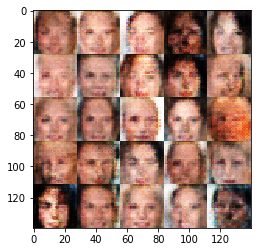

Epoch 1/1:	 Discriminator loss: 1.617	 Generator loss: 0.374
Epoch 1/1:	 Discriminator loss: 1.409	 Generator loss: 0.752
Epoch 1/1:	 Discriminator loss: 1.227	 Generator loss: 1.302
Epoch 1/1:	 Discriminator loss: 1.218	 Generator loss: 0.810
Epoch 1/1:	 Discriminator loss: 1.446	 Generator loss: 0.502
Epoch 1/1:	 Discriminator loss: 1.335	 Generator loss: 0.600
Epoch 1/1:	 Discriminator loss: 1.255	 Generator loss: 0.773
Epoch 1/1:	 Discriminator loss: 1.312	 Generator loss: 1.153
Epoch 1/1:	 Discriminator loss: 1.259	 Generator loss: 0.965
Epoch 1/1:	 Discriminator loss: 1.240	 Generator loss: 0.827


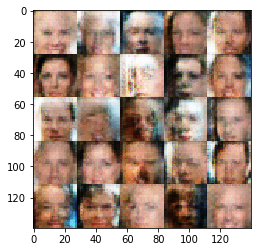

Epoch 1/1:	 Discriminator loss: 1.142	 Generator loss: 0.694
Epoch 1/1:	 Discriminator loss: 1.415	 Generator loss: 0.560
Epoch 1/1:	 Discriminator loss: 1.494	 Generator loss: 0.517
Epoch 1/1:	 Discriminator loss: 1.341	 Generator loss: 0.781
Epoch 1/1:	 Discriminator loss: 1.329	 Generator loss: 0.699
Epoch 1/1:	 Discriminator loss: 1.454	 Generator loss: 0.475
Epoch 1/1:	 Discriminator loss: 1.433	 Generator loss: 0.461
Epoch 1/1:	 Discriminator loss: 1.498	 Generator loss: 0.403
Epoch 1/1:	 Discriminator loss: 1.311	 Generator loss: 0.570
Epoch 1/1:	 Discriminator loss: 1.392	 Generator loss: 0.819


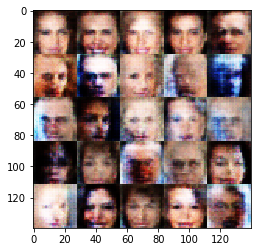

Epoch 1/1:	 Discriminator loss: 1.407	 Generator loss: 0.504
Epoch 1/1:	 Discriminator loss: 1.185	 Generator loss: 0.799
Epoch 1/1:	 Discriminator loss: 1.476	 Generator loss: 0.480
Epoch 1/1:	 Discriminator loss: 1.454	 Generator loss: 0.510
Epoch 1/1:	 Discriminator loss: 1.441	 Generator loss: 0.462
Epoch 1/1:	 Discriminator loss: 1.385	 Generator loss: 0.533
Epoch 1/1:	 Discriminator loss: 1.354	 Generator loss: 0.642
Epoch 1/1:	 Discriminator loss: 1.342	 Generator loss: 0.598
Epoch 1/1:	 Discriminator loss: 1.186	 Generator loss: 0.901
Epoch 1/1:	 Discriminator loss: 1.400	 Generator loss: 0.550


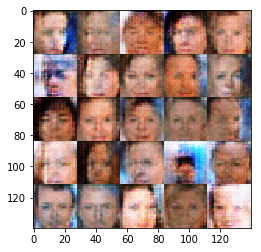

Epoch 1/1:	 Discriminator loss: 1.413	 Generator loss: 0.531
Epoch 1/1:	 Discriminator loss: 1.337	 Generator loss: 0.600
Epoch 1/1:	 Discriminator loss: 1.360	 Generator loss: 0.629
Epoch 1/1:	 Discriminator loss: 1.407	 Generator loss: 0.524
Epoch 1/1:	 Discriminator loss: 1.265	 Generator loss: 0.581
Epoch 1/1:	 Discriminator loss: 1.552	 Generator loss: 0.421
Epoch 1/1:	 Discriminator loss: 1.254	 Generator loss: 0.797
Epoch 1/1:	 Discriminator loss: 1.204	 Generator loss: 0.758
Epoch 1/1:	 Discriminator loss: 1.208	 Generator loss: 0.828
Epoch 1/1:	 Discriminator loss: 1.507	 Generator loss: 0.506


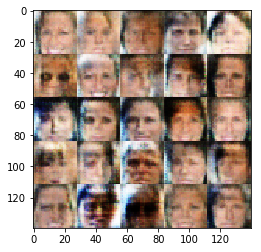

Epoch 1/1:	 Discriminator loss: 1.469	 Generator loss: 0.464
Epoch 1/1:	 Discriminator loss: 1.318	 Generator loss: 0.577
Epoch 1/1:	 Discriminator loss: 1.364	 Generator loss: 0.661
Epoch 1/1:	 Discriminator loss: 1.373	 Generator loss: 0.502
Epoch 1/1:	 Discriminator loss: 1.348	 Generator loss: 0.510
Epoch 1/1:	 Discriminator loss: 1.264	 Generator loss: 0.659
Epoch 1/1:	 Discriminator loss: 1.250	 Generator loss: 0.878
Epoch 1/1:	 Discriminator loss: 1.214	 Generator loss: 0.770
Epoch 1/1:	 Discriminator loss: 1.381	 Generator loss: 0.609
Epoch 1/1:	 Discriminator loss: 1.274	 Generator loss: 0.733


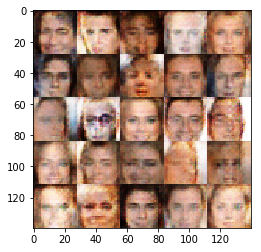

Epoch 1/1:	 Discriminator loss: 1.185	 Generator loss: 0.834
Epoch 1/1:	 Discriminator loss: 1.239	 Generator loss: 0.841
Epoch 1/1:	 Discriminator loss: 1.502	 Generator loss: 0.445
Epoch 1/1:	 Discriminator loss: 1.427	 Generator loss: 0.542
Epoch 1/1:	 Discriminator loss: 1.765	 Generator loss: 0.311
Epoch 1/1:	 Discriminator loss: 1.317	 Generator loss: 0.995
Epoch 1/1:	 Discriminator loss: 1.312	 Generator loss: 0.586
Epoch 1/1:	 Discriminator loss: 1.544	 Generator loss: 0.391
Epoch 1/1:	 Discriminator loss: 1.190	 Generator loss: 1.014
Epoch 1/1:	 Discriminator loss: 1.283	 Generator loss: 1.338


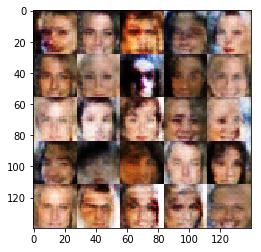

Epoch 1/1:	 Discriminator loss: 1.304	 Generator loss: 0.609
Epoch 1/1:	 Discriminator loss: 1.371	 Generator loss: 0.566
Epoch 1/1:	 Discriminator loss: 1.564	 Generator loss: 0.411
Epoch 1/1:	 Discriminator loss: 1.397	 Generator loss: 1.691
Epoch 1/1:	 Discriminator loss: 1.351	 Generator loss: 0.784
Epoch 1/1:	 Discriminator loss: 1.366	 Generator loss: 0.572
Epoch 1/1:	 Discriminator loss: 1.326	 Generator loss: 0.594
Epoch 1/1:	 Discriminator loss: 1.262	 Generator loss: 0.878
Epoch 1/1:	 Discriminator loss: 1.271	 Generator loss: 0.632
Epoch 1/1:	 Discriminator loss: 1.581	 Generator loss: 0.427


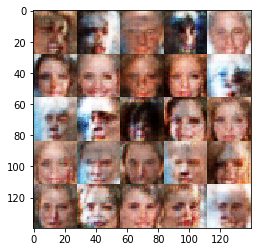

Epoch 1/1:	 Discriminator loss: 1.359	 Generator loss: 0.552
Epoch 1/1:	 Discriminator loss: 1.087	 Generator loss: 1.044
Epoch 1/1:	 Discriminator loss: 1.534	 Generator loss: 0.423
Epoch 1/1:	 Discriminator loss: 1.263	 Generator loss: 0.690
Epoch 1/1:	 Discriminator loss: 1.460	 Generator loss: 0.516
Epoch 1/1:	 Discriminator loss: 1.409	 Generator loss: 0.596
Epoch 1/1:	 Discriminator loss: 1.450	 Generator loss: 0.486
Epoch 1/1:	 Discriminator loss: 1.235	 Generator loss: 0.648
Epoch 1/1:	 Discriminator loss: 1.220	 Generator loss: 1.000
Epoch 1/1:	 Discriminator loss: 1.320	 Generator loss: 0.577


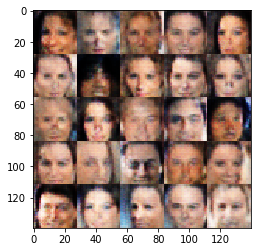

Epoch 1/1:	 Discriminator loss: 1.338	 Generator loss: 0.573
Epoch 1/1:	 Discriminator loss: 1.263	 Generator loss: 0.643
Epoch 1/1:	 Discriminator loss: 1.350	 Generator loss: 1.396
Epoch 1/1:	 Discriminator loss: 1.327	 Generator loss: 1.207
Epoch 1/1:	 Discriminator loss: 1.456	 Generator loss: 0.492
Epoch 1/1:	 Discriminator loss: 1.329	 Generator loss: 0.586
Epoch 1/1:	 Discriminator loss: 1.437	 Generator loss: 0.501
Epoch 1/1:	 Discriminator loss: 1.211	 Generator loss: 0.872
Epoch 1/1:	 Discriminator loss: 1.312	 Generator loss: 0.602
Epoch 1/1:	 Discriminator loss: 1.933	 Generator loss: 0.251


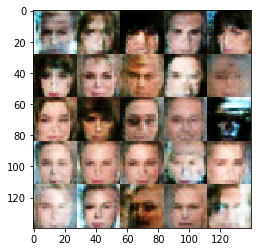

Epoch 1/1:	 Discriminator loss: 1.264	 Generator loss: 0.649
Epoch 1/1:	 Discriminator loss: 1.524	 Generator loss: 0.473
Epoch 1/1:	 Discriminator loss: 1.257	 Generator loss: 0.593
Epoch 1/1:	 Discriminator loss: 1.337	 Generator loss: 0.592
Epoch 1/1:	 Discriminator loss: 1.313	 Generator loss: 0.838
Epoch 1/1:	 Discriminator loss: 1.186	 Generator loss: 0.875
Epoch 1/1:	 Discriminator loss: 1.389	 Generator loss: 0.599
Epoch 1/1:	 Discriminator loss: 1.244	 Generator loss: 0.707
Epoch 1/1:	 Discriminator loss: 1.227	 Generator loss: 0.755
Epoch 1/1:	 Discriminator loss: 1.263	 Generator loss: 0.731


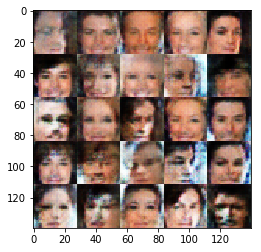

Epoch 1/1:	 Discriminator loss: 1.272	 Generator loss: 0.832
Epoch 1/1:	 Discriminator loss: 1.488	 Generator loss: 0.455
Epoch 1/1:	 Discriminator loss: 1.245	 Generator loss: 0.754
Epoch 1/1:	 Discriminator loss: 1.338	 Generator loss: 1.429
Epoch 1/1:	 Discriminator loss: 1.324	 Generator loss: 0.657
Epoch 1/1:	 Discriminator loss: 1.382	 Generator loss: 0.533
Epoch 1/1:	 Discriminator loss: 1.202	 Generator loss: 0.826
Epoch 1/1:	 Discriminator loss: 1.452	 Generator loss: 0.516
Epoch 1/1:	 Discriminator loss: 1.419	 Generator loss: 0.497
Epoch 1/1:	 Discriminator loss: 1.412	 Generator loss: 0.746


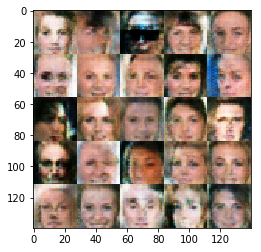

Epoch 1/1:	 Discriminator loss: 1.434	 Generator loss: 0.661
Epoch 1/1:	 Discriminator loss: 1.351	 Generator loss: 0.592
Epoch 1/1:	 Discriminator loss: 1.417	 Generator loss: 0.504
Epoch 1/1:	 Discriminator loss: 1.466	 Generator loss: 0.485
Epoch 1/1:	 Discriminator loss: 1.083	 Generator loss: 0.773
Epoch 1/1:	 Discriminator loss: 1.451	 Generator loss: 0.435
Epoch 1/1:	 Discriminator loss: 1.266	 Generator loss: 0.697
Epoch 1/1:	 Discriminator loss: 1.231	 Generator loss: 0.755
Epoch 1/1:	 Discriminator loss: 1.178	 Generator loss: 0.781
Epoch 1/1:	 Discriminator loss: 1.232	 Generator loss: 0.782


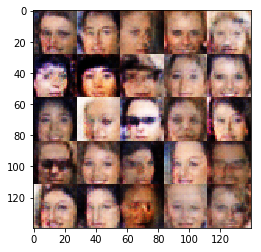

Epoch 1/1:	 Discriminator loss: 1.587	 Generator loss: 0.463
Epoch 1/1:	 Discriminator loss: 1.549	 Generator loss: 0.516
Epoch 1/1:	 Discriminator loss: 1.480	 Generator loss: 0.556
Epoch 1/1:	 Discriminator loss: 1.301	 Generator loss: 0.553
Epoch 1/1:	 Discriminator loss: 1.467	 Generator loss: 0.504
Epoch 1/1:	 Discriminator loss: 1.292	 Generator loss: 0.732
Epoch 1/1:	 Discriminator loss: 1.256	 Generator loss: 0.791
Epoch 1/1:	 Discriminator loss: 1.253	 Generator loss: 0.760
Epoch 1/1:	 Discriminator loss: 1.273	 Generator loss: 0.711
Epoch 1/1:	 Discriminator loss: 1.415	 Generator loss: 0.521


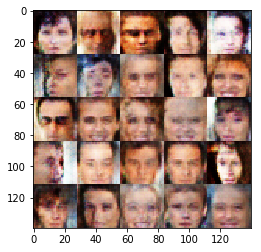

Epoch 1/1:	 Discriminator loss: 1.192	 Generator loss: 0.923
Epoch 1/1:	 Discriminator loss: 1.447	 Generator loss: 0.487
Epoch 1/1:	 Discriminator loss: 1.206	 Generator loss: 1.101
Epoch 1/1:	 Discriminator loss: 1.339	 Generator loss: 0.570
Epoch 1/1:	 Discriminator loss: 1.355	 Generator loss: 0.514
Epoch 1/1:	 Discriminator loss: 1.137	 Generator loss: 1.087
Epoch 1/1:	 Discriminator loss: 1.188	 Generator loss: 0.737
Epoch 1/1:	 Discriminator loss: 1.630	 Generator loss: 0.356
Epoch 1/1:	 Discriminator loss: 1.259	 Generator loss: 0.645
Epoch 1/1:	 Discriminator loss: 1.433	 Generator loss: 0.742


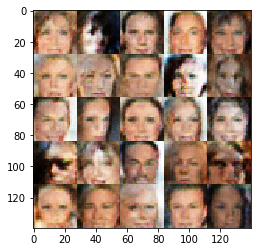

Epoch 1/1:	 Discriminator loss: 1.366	 Generator loss: 0.679
Epoch 1/1:	 Discriminator loss: 1.187	 Generator loss: 0.845
Epoch 1/1:	 Discriminator loss: 1.483	 Generator loss: 0.444
Epoch 1/1:	 Discriminator loss: 1.530	 Generator loss: 0.430
Epoch 1/1:	 Discriminator loss: 1.178	 Generator loss: 0.742
Epoch 1/1:	 Discriminator loss: 1.362	 Generator loss: 0.597
Epoch 1/1:	 Discriminator loss: 1.351	 Generator loss: 0.615
Epoch 1/1:	 Discriminator loss: 1.249	 Generator loss: 0.673
Epoch 1/1:	 Discriminator loss: 1.340	 Generator loss: 0.623
Epoch 1/1:	 Discriminator loss: 1.313	 Generator loss: 0.587


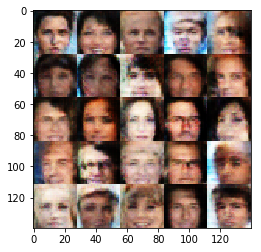

Epoch 1/1:	 Discriminator loss: 1.202	 Generator loss: 0.863
Epoch 1/1:	 Discriminator loss: 1.176	 Generator loss: 0.921
Epoch 1/1:	 Discriminator loss: 1.516	 Generator loss: 0.479
Epoch 1/1:	 Discriminator loss: 1.279	 Generator loss: 0.734
Epoch 1/1:	 Discriminator loss: 1.279	 Generator loss: 0.734
Epoch 1/1:	 Discriminator loss: 1.437	 Generator loss: 0.531
Epoch 1/1:	 Discriminator loss: 1.330	 Generator loss: 0.674
Epoch 1/1:	 Discriminator loss: 1.177	 Generator loss: 0.819
Epoch 1/1:	 Discriminator loss: 1.291	 Generator loss: 0.656
Epoch 1/1:	 Discriminator loss: 1.495	 Generator loss: 0.491


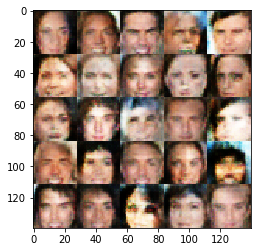

Epoch 1/1:	 Discriminator loss: 1.295	 Generator loss: 0.775
Epoch 1/1:	 Discriminator loss: 1.557	 Generator loss: 0.424
Epoch 1/1:	 Discriminator loss: 1.246	 Generator loss: 0.796
Epoch 1/1:	 Discriminator loss: 1.848	 Generator loss: 0.304
Epoch 1/1:	 Discriminator loss: 1.480	 Generator loss: 0.436
Epoch 1/1:	 Discriminator loss: 1.331	 Generator loss: 0.751
Epoch 1/1:	 Discriminator loss: 1.243	 Generator loss: 0.674
Epoch 1/1:	 Discriminator loss: 1.596	 Generator loss: 0.375
Epoch 1/1:	 Discriminator loss: 1.372	 Generator loss: 0.544
Epoch 1/1:	 Discriminator loss: 1.247	 Generator loss: 0.718


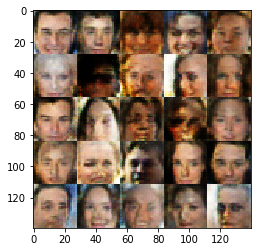

Epoch 1/1:	 Discriminator loss: 1.385	 Generator loss: 0.511
Epoch 1/1:	 Discriminator loss: 1.561	 Generator loss: 0.422
Epoch 1/1:	 Discriminator loss: 1.203	 Generator loss: 0.770
Epoch 1/1:	 Discriminator loss: 1.714	 Generator loss: 0.369
Epoch 1/1:	 Discriminator loss: 1.315	 Generator loss: 0.654
Epoch 1/1:	 Discriminator loss: 1.403	 Generator loss: 1.267
Epoch 1/1:	 Discriminator loss: 1.204	 Generator loss: 0.876
Epoch 1/1:	 Discriminator loss: 1.504	 Generator loss: 0.433
Epoch 1/1:	 Discriminator loss: 1.365	 Generator loss: 0.785
Epoch 1/1:	 Discriminator loss: 1.222	 Generator loss: 0.650


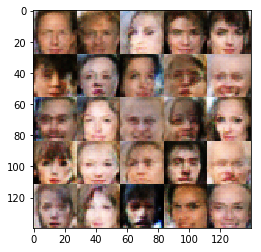

Epoch 1/1:	 Discriminator loss: 1.473	 Generator loss: 0.440
Epoch 1/1:	 Discriminator loss: 1.305	 Generator loss: 0.655
Epoch 1/1:	 Discriminator loss: 1.382	 Generator loss: 0.540
Epoch 1/1:	 Discriminator loss: 1.690	 Generator loss: 0.338
Epoch 1/1:	 Discriminator loss: 1.634	 Generator loss: 0.373
Epoch 1/1:	 Discriminator loss: 1.272	 Generator loss: 0.663
Epoch 1/1:	 Discriminator loss: 1.448	 Generator loss: 0.440
Epoch 1/1:	 Discriminator loss: 1.469	 Generator loss: 0.432
Epoch 1/1:	 Discriminator loss: 1.333	 Generator loss: 0.618
Epoch 1/1:	 Discriminator loss: 1.282	 Generator loss: 0.550


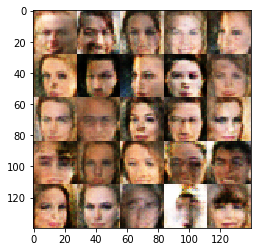

Epoch 1/1:	 Discriminator loss: 1.461	 Generator loss: 0.499
Epoch 1/1:	 Discriminator loss: 1.245	 Generator loss: 0.593
Epoch 1/1:	 Discriminator loss: 1.934	 Generator loss: 0.244
Epoch 1/1:	 Discriminator loss: 1.395	 Generator loss: 0.576
Epoch 1/1:	 Discriminator loss: 1.606	 Generator loss: 0.353
Epoch 1/1:	 Discriminator loss: 1.255	 Generator loss: 0.839
Epoch 1/1:	 Discriminator loss: 1.401	 Generator loss: 0.508
Epoch 1/1:	 Discriminator loss: 1.181	 Generator loss: 0.776
Epoch 1/1:	 Discriminator loss: 1.404	 Generator loss: 0.551
Epoch 1/1:	 Discriminator loss: 1.211	 Generator loss: 0.857


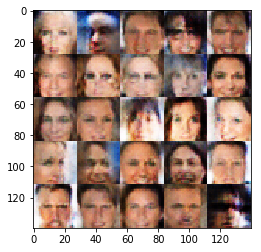

Epoch 1/1:	 Discriminator loss: 1.290	 Generator loss: 0.697
Epoch 1/1:	 Discriminator loss: 1.236	 Generator loss: 0.598
Epoch 1/1:	 Discriminator loss: 1.420	 Generator loss: 0.488
Epoch 1/1:	 Discriminator loss: 1.527	 Generator loss: 0.445
Epoch 1/1:	 Discriminator loss: 1.155	 Generator loss: 0.855
Epoch 1/1:	 Discriminator loss: 1.503	 Generator loss: 0.473
Epoch 1/1:	 Discriminator loss: 1.427	 Generator loss: 0.506
Epoch 1/1:	 Discriminator loss: 1.417	 Generator loss: 0.538
Epoch 1/1:	 Discriminator loss: 1.236	 Generator loss: 0.651
Epoch 1/1:	 Discriminator loss: 1.197	 Generator loss: 0.820


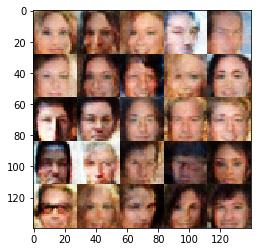

Epoch 1/1:	 Discriminator loss: 1.429	 Generator loss: 0.483
Epoch 1/1:	 Discriminator loss: 1.525	 Generator loss: 0.454
Epoch 1/1:	 Discriminator loss: 1.474	 Generator loss: 0.488
Epoch 1/1:	 Discriminator loss: 1.338	 Generator loss: 0.832
Epoch 1/1:	 Discriminator loss: 1.344	 Generator loss: 0.721
Epoch 1/1:	 Discriminator loss: 1.246	 Generator loss: 0.642
Epoch 1/1:	 Discriminator loss: 1.342	 Generator loss: 0.536
Epoch 1/1:	 Discriminator loss: 1.274	 Generator loss: 0.719
Epoch 1/1:	 Discriminator loss: 1.372	 Generator loss: 0.629
Epoch 1/1:	 Discriminator loss: 1.467	 Generator loss: 0.494


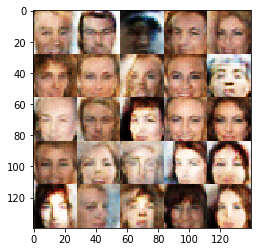

Epoch 1/1:	 Discriminator loss: 1.501	 Generator loss: 0.493
Epoch 1/1:	 Discriminator loss: 1.443	 Generator loss: 0.517
Epoch 1/1:	 Discriminator loss: 1.301	 Generator loss: 0.556
Epoch 1/1:	 Discriminator loss: 1.412	 Generator loss: 0.514
Epoch 1/1:	 Discriminator loss: 1.268	 Generator loss: 0.653
Epoch 1/1:	 Discriminator loss: 1.248	 Generator loss: 0.669
Epoch 1/1:	 Discriminator loss: 1.404	 Generator loss: 0.574
Epoch 1/1:	 Discriminator loss: 1.260	 Generator loss: 0.751
Epoch 1/1:	 Discriminator loss: 1.362	 Generator loss: 0.584
Epoch 1/1:	 Discriminator loss: 1.294	 Generator loss: 0.614


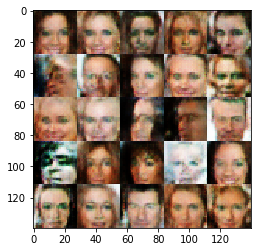

Epoch 1/1:	 Discriminator loss: 1.602	 Generator loss: 0.389
Epoch 1/1:	 Discriminator loss: 1.299	 Generator loss: 0.608
Epoch 1/1:	 Discriminator loss: 1.210	 Generator loss: 0.808
Epoch 1/1:	 Discriminator loss: 1.512	 Generator loss: 0.429
Epoch 1/1:	 Discriminator loss: 1.282	 Generator loss: 0.692
Epoch 1/1:	 Discriminator loss: 1.478	 Generator loss: 0.520
Epoch 1/1:	 Discriminator loss: 1.299	 Generator loss: 0.731
Epoch 1/1:	 Discriminator loss: 1.226	 Generator loss: 0.826
Epoch 1/1:	 Discriminator loss: 1.540	 Generator loss: 0.470
Epoch 1/1:	 Discriminator loss: 1.273	 Generator loss: 0.686


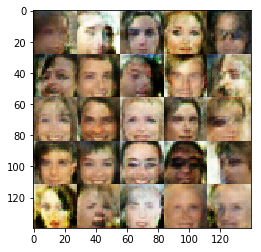

Epoch 1/1:	 Discriminator loss: 1.377	 Generator loss: 0.519
Epoch 1/1:	 Discriminator loss: 1.178	 Generator loss: 0.872
Epoch 1/1:	 Discriminator loss: 1.443	 Generator loss: 0.539
Epoch 1/1:	 Discriminator loss: 1.245	 Generator loss: 0.696
Epoch 1/1:	 Discriminator loss: 1.217	 Generator loss: 0.755
Epoch 1/1:	 Discriminator loss: 1.254	 Generator loss: 0.621
Epoch 1/1:	 Discriminator loss: 1.411	 Generator loss: 0.552
Epoch 1/1:	 Discriminator loss: 1.382	 Generator loss: 0.530
Epoch 1/1:	 Discriminator loss: 1.383	 Generator loss: 0.481
Epoch 1/1:	 Discriminator loss: 1.269	 Generator loss: 0.676


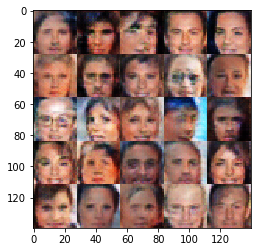

Epoch 1/1:	 Discriminator loss: 1.174	 Generator loss: 1.137
Epoch 1/1:	 Discriminator loss: 1.263	 Generator loss: 0.654
Epoch 1/1:	 Discriminator loss: 1.301	 Generator loss: 0.564
Epoch 1/1:	 Discriminator loss: 1.533	 Generator loss: 0.441
Epoch 1/1:	 Discriminator loss: 1.331	 Generator loss: 0.625
Epoch 1/1:	 Discriminator loss: 1.369	 Generator loss: 0.584
Epoch 1/1:	 Discriminator loss: 1.298	 Generator loss: 0.618
Epoch 1/1:	 Discriminator loss: 1.374	 Generator loss: 0.555
Epoch 1/1:	 Discriminator loss: 1.697	 Generator loss: 0.322
Epoch 1/1:	 Discriminator loss: 1.564	 Generator loss: 0.376


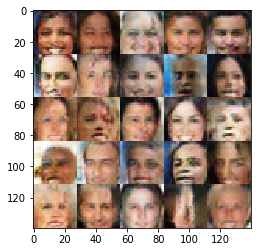

Epoch 1/1:	 Discriminator loss: 1.130	 Generator loss: 0.922
Epoch 1/1:	 Discriminator loss: 1.170	 Generator loss: 0.778
Epoch 1/1:	 Discriminator loss: 1.461	 Generator loss: 0.459
Epoch 1/1:	 Discriminator loss: 1.198	 Generator loss: 0.831
Epoch 1/1:	 Discriminator loss: 1.124	 Generator loss: 0.807
Epoch 1/1:	 Discriminator loss: 1.188	 Generator loss: 0.902
Epoch 1/1:	 Discriminator loss: 1.421	 Generator loss: 1.292
Epoch 1/1:	 Discriminator loss: 1.377	 Generator loss: 0.593
Epoch 1/1:	 Discriminator loss: 1.432	 Generator loss: 0.516
Epoch 1/1:	 Discriminator loss: 1.357	 Generator loss: 0.524


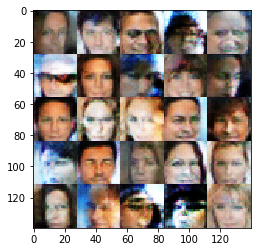

Epoch 1/1:	 Discriminator loss: 1.282	 Generator loss: 0.890
Epoch 1/1:	 Discriminator loss: 1.207	 Generator loss: 0.762
Epoch 1/1:	 Discriminator loss: 1.410	 Generator loss: 0.520
Epoch 1/1:	 Discriminator loss: 1.714	 Generator loss: 0.338
Epoch 1/1:	 Discriminator loss: 1.087	 Generator loss: 1.017
Epoch 1/1:	 Discriminator loss: 1.522	 Generator loss: 0.447
Epoch 1/1:	 Discriminator loss: 1.291	 Generator loss: 0.613
Epoch 1/1:	 Discriminator loss: 1.308	 Generator loss: 0.826
Epoch 1/1:	 Discriminator loss: 1.531	 Generator loss: 0.469
Epoch 1/1:	 Discriminator loss: 1.294	 Generator loss: 0.761


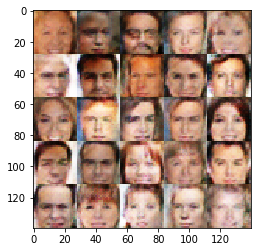

Epoch 1/1:	 Discriminator loss: 1.331	 Generator loss: 0.565
Epoch 1/1:	 Discriminator loss: 1.349	 Generator loss: 0.538
Epoch 1/1:	 Discriminator loss: 1.151	 Generator loss: 1.055
Epoch 1/1:	 Discriminator loss: 1.304	 Generator loss: 0.630
Epoch 1/1:	 Discriminator loss: 1.261	 Generator loss: 0.707
Epoch 1/1:	 Discriminator loss: 1.522	 Generator loss: 0.403
Epoch 1/1:	 Discriminator loss: 1.259	 Generator loss: 1.001
Epoch 1/1:	 Discriminator loss: 1.076	 Generator loss: 0.871
Epoch 1/1:	 Discriminator loss: 1.597	 Generator loss: 0.401
Epoch 1/1:	 Discriminator loss: 1.179	 Generator loss: 0.898


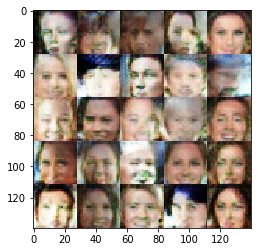

Epoch 1/1:	 Discriminator loss: 1.263	 Generator loss: 0.882
Epoch 1/1:	 Discriminator loss: 1.868	 Generator loss: 0.275
Epoch 1/1:	 Discriminator loss: 1.361	 Generator loss: 0.548
Epoch 1/1:	 Discriminator loss: 1.265	 Generator loss: 0.667
Epoch 1/1:	 Discriminator loss: 1.286	 Generator loss: 0.817
Epoch 1/1:	 Discriminator loss: 1.514	 Generator loss: 0.405
Epoch 1/1:	 Discriminator loss: 1.334	 Generator loss: 0.622
Epoch 1/1:	 Discriminator loss: 1.481	 Generator loss: 0.444
Epoch 1/1:	 Discriminator loss: 1.273	 Generator loss: 0.655
Epoch 1/1:	 Discriminator loss: 1.796	 Generator loss: 0.291


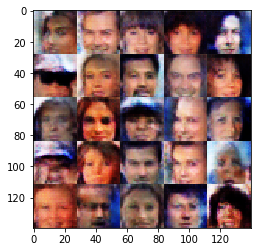

Epoch 1/1:	 Discriminator loss: 1.196	 Generator loss: 0.799
Epoch 1/1:	 Discriminator loss: 1.355	 Generator loss: 0.565
Epoch 1/1:	 Discriminator loss: 0.966	 Generator loss: 0.956
Epoch 1/1:	 Discriminator loss: 1.316	 Generator loss: 0.637
Epoch 1/1:	 Discriminator loss: 1.193	 Generator loss: 0.705
Epoch 1/1:	 Discriminator loss: 1.261	 Generator loss: 0.707
Epoch 1/1:	 Discriminator loss: 1.221	 Generator loss: 1.488
Epoch 1/1:	 Discriminator loss: 1.637	 Generator loss: 0.361
Epoch 1/1:	 Discriminator loss: 1.206	 Generator loss: 0.717
Epoch 1/1:	 Discriminator loss: 1.240	 Generator loss: 0.641


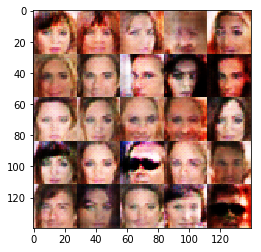

Epoch 1/1:	 Discriminator loss: 1.477	 Generator loss: 0.455
Epoch 1/1:	 Discriminator loss: 1.460	 Generator loss: 0.460
Epoch 1/1:	 Discriminator loss: 1.727	 Generator loss: 0.312
Epoch 1/1:	 Discriminator loss: 1.316	 Generator loss: 0.827
Epoch 1/1:	 Discriminator loss: 1.504	 Generator loss: 0.435
Epoch 1/1:	 Discriminator loss: 1.513	 Generator loss: 0.462
Epoch 1/1:	 Discriminator loss: 1.863	 Generator loss: 0.267
Epoch 1/1:	 Discriminator loss: 1.396	 Generator loss: 0.494
Epoch 1/1:	 Discriminator loss: 1.176	 Generator loss: 0.771
Epoch 1/1:	 Discriminator loss: 1.393	 Generator loss: 0.539


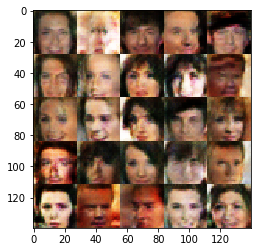

Epoch 1/1:	 Discriminator loss: 1.334	 Generator loss: 0.727
Epoch 1/1:	 Discriminator loss: 1.389	 Generator loss: 0.620
Epoch 1/1:	 Discriminator loss: 1.476	 Generator loss: 0.486
Epoch 1/1:	 Discriminator loss: 1.387	 Generator loss: 0.562
Epoch 1/1:	 Discriminator loss: 1.500	 Generator loss: 0.404
Epoch 1/1:	 Discriminator loss: 1.806	 Generator loss: 0.274
Epoch 1/1:	 Discriminator loss: 1.299	 Generator loss: 0.585
Epoch 1/1:	 Discriminator loss: 1.184	 Generator loss: 0.839
Epoch 1/1:	 Discriminator loss: 1.334	 Generator loss: 0.527
Epoch 1/1:	 Discriminator loss: 1.293	 Generator loss: 0.683


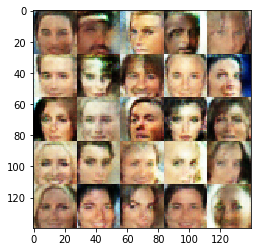

Epoch 1/1:	 Discriminator loss: 1.299	 Generator loss: 0.637
Epoch 1/1:	 Discriminator loss: 1.377	 Generator loss: 0.552
Epoch 1/1:	 Discriminator loss: 1.397	 Generator loss: 0.492
Epoch 1/1:	 Discriminator loss: 1.148	 Generator loss: 0.913
Epoch 1/1:	 Discriminator loss: 1.326	 Generator loss: 0.638
Epoch 1/1:	 Discriminator loss: 1.485	 Generator loss: 0.477
Epoch 1/1:	 Discriminator loss: 1.260	 Generator loss: 0.986
Epoch 1/1:	 Discriminator loss: 1.345	 Generator loss: 0.518
Epoch 1/1:	 Discriminator loss: 1.432	 Generator loss: 0.495
Epoch 1/1:	 Discriminator loss: 1.316	 Generator loss: 0.685


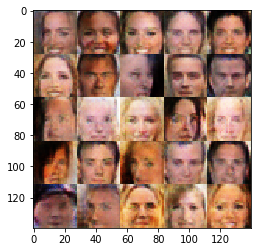

Epoch 1/1:	 Discriminator loss: 1.358	 Generator loss: 0.675
Epoch 1/1:	 Discriminator loss: 1.539	 Generator loss: 0.429
Epoch 1/1:	 Discriminator loss: 1.472	 Generator loss: 0.565
Epoch 1/1:	 Discriminator loss: 1.428	 Generator loss: 0.553
Epoch 1/1:	 Discriminator loss: 1.368	 Generator loss: 0.529
Epoch 1/1:	 Discriminator loss: 1.277	 Generator loss: 0.607
Epoch 1/1:	 Discriminator loss: 1.143	 Generator loss: 0.967
Epoch 1/1:	 Discriminator loss: 1.456	 Generator loss: 0.480
Epoch 1/1:	 Discriminator loss: 1.206	 Generator loss: 0.707
Epoch 1/1:	 Discriminator loss: 1.535	 Generator loss: 0.416


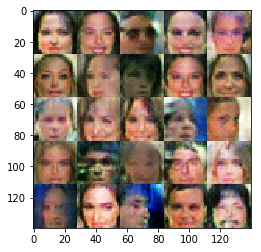

Epoch 1/1:	 Discriminator loss: 1.367	 Generator loss: 0.610
Epoch 1/1:	 Discriminator loss: 1.686	 Generator loss: 0.348
Epoch 1/1:	 Discriminator loss: 1.396	 Generator loss: 0.585
Epoch 1/1:	 Discriminator loss: 1.180	 Generator loss: 0.789
Epoch 1/1:	 Discriminator loss: 1.313	 Generator loss: 0.542
Epoch 1/1:	 Discriminator loss: 1.223	 Generator loss: 0.677
Epoch 1/1:	 Discriminator loss: 1.237	 Generator loss: 1.113
Epoch 1/1:	 Discriminator loss: 1.294	 Generator loss: 0.712
Epoch 1/1:	 Discriminator loss: 1.365	 Generator loss: 0.535
Epoch 1/1:	 Discriminator loss: 1.263	 Generator loss: 0.737


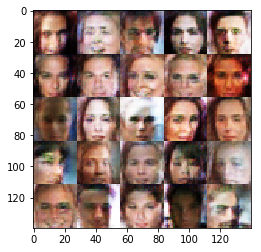

Epoch 1/1:	 Discriminator loss: 1.248	 Generator loss: 0.680
Epoch 1/1:	 Discriminator loss: 1.126	 Generator loss: 0.806
Epoch 1/1:	 Discriminator loss: 1.451	 Generator loss: 0.515
Epoch 1/1:	 Discriminator loss: 1.269	 Generator loss: 0.761
Epoch 1/1:	 Discriminator loss: 1.239	 Generator loss: 0.708
Epoch 1/1:	 Discriminator loss: 1.595	 Generator loss: 0.478
Epoch 1/1:	 Discriminator loss: 1.499	 Generator loss: 0.418
Epoch 1/1:	 Discriminator loss: 1.219	 Generator loss: 0.667
Epoch 1/1:	 Discriminator loss: 1.098	 Generator loss: 0.896
Epoch 1/1:	 Discriminator loss: 1.319	 Generator loss: 0.575


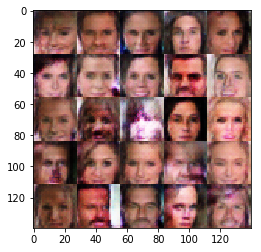

Epoch 1/1:	 Discriminator loss: 1.371	 Generator loss: 0.530
Epoch 1/1:	 Discriminator loss: 1.452	 Generator loss: 0.467
Epoch 1/1:	 Discriminator loss: 1.321	 Generator loss: 1.088
Epoch 1/1:	 Discriminator loss: 1.254	 Generator loss: 0.681
Epoch 1/1:	 Discriminator loss: 1.430	 Generator loss: 0.456
Epoch 1/1:	 Discriminator loss: 1.218	 Generator loss: 1.214
Epoch 1/1:	 Discriminator loss: 1.254	 Generator loss: 0.636
Epoch 1/1:	 Discriminator loss: 1.180	 Generator loss: 0.783
Epoch 1/1:	 Discriminator loss: 1.439	 Generator loss: 0.505
Epoch 1/1:	 Discriminator loss: 1.211	 Generator loss: 0.694


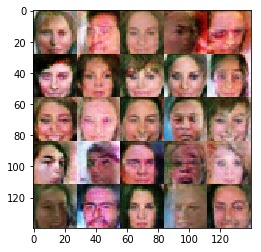

Epoch 1/1:	 Discriminator loss: 1.367	 Generator loss: 0.533
Epoch 1/1:	 Discriminator loss: 1.453	 Generator loss: 0.523
Epoch 1/1:	 Discriminator loss: 1.173	 Generator loss: 0.713
Epoch 1/1:	 Discriminator loss: 1.390	 Generator loss: 0.473
Epoch 1/1:	 Discriminator loss: 1.379	 Generator loss: 0.582
Epoch 1/1:	 Discriminator loss: 1.764	 Generator loss: 0.324
Epoch 1/1:	 Discriminator loss: 1.401	 Generator loss: 0.486
Epoch 1/1:	 Discriminator loss: 1.270	 Generator loss: 0.605
Epoch 1/1:	 Discriminator loss: 1.459	 Generator loss: 1.025
Epoch 1/1:	 Discriminator loss: 1.481	 Generator loss: 0.484


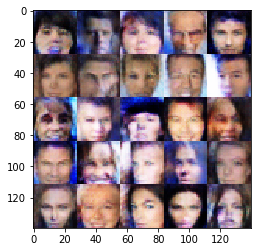

Epoch 1/1:	 Discriminator loss: 1.189	 Generator loss: 0.776
Epoch 1/1:	 Discriminator loss: 1.258	 Generator loss: 0.760
Epoch 1/1:	 Discriminator loss: 1.341	 Generator loss: 0.661
Epoch 1/1:	 Discriminator loss: 1.162	 Generator loss: 0.770
Epoch 1/1:	 Discriminator loss: 1.201	 Generator loss: 0.612
Epoch 1/1:	 Discriminator loss: 1.652	 Generator loss: 0.379
Epoch 1/1:	 Discriminator loss: 1.470	 Generator loss: 0.429
Epoch 1/1:	 Discriminator loss: 1.284	 Generator loss: 0.576
Epoch 1/1:	 Discriminator loss: 1.106	 Generator loss: 1.525
Epoch 1/1:	 Discriminator loss: 1.274	 Generator loss: 0.661


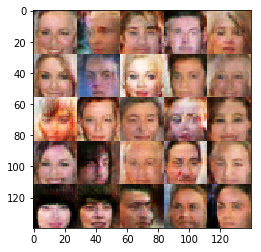

Epoch 1/1:	 Discriminator loss: 1.217	 Generator loss: 0.869
Epoch 1/1:	 Discriminator loss: 1.286	 Generator loss: 0.634
Epoch 1/1:	 Discriminator loss: 1.216	 Generator loss: 0.675
Epoch 1/1:	 Discriminator loss: 1.500	 Generator loss: 0.470
Epoch 1/1:	 Discriminator loss: 1.244	 Generator loss: 0.616
Epoch 1/1:	 Discriminator loss: 1.659	 Generator loss: 0.386
Epoch 1/1:	 Discriminator loss: 1.630	 Generator loss: 0.344
Epoch 1/1:	 Discriminator loss: 1.157	 Generator loss: 0.929
Epoch 1/1:	 Discriminator loss: 1.256	 Generator loss: 0.727
Epoch 1/1:	 Discriminator loss: 1.264	 Generator loss: 0.650


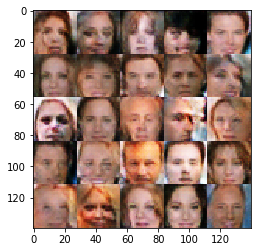

Epoch 1/1:	 Discriminator loss: 1.538	 Generator loss: 0.474
Epoch 1/1:	 Discriminator loss: 1.200	 Generator loss: 0.910
Epoch 1/1:	 Discriminator loss: 1.244	 Generator loss: 0.698
Epoch 1/1:	 Discriminator loss: 1.414	 Generator loss: 0.600
Epoch 1/1:	 Discriminator loss: 1.493	 Generator loss: 0.478
Epoch 1/1:	 Discriminator loss: 1.543	 Generator loss: 0.400
Epoch 1/1:	 Discriminator loss: 1.238	 Generator loss: 1.058
Epoch 1/1:	 Discriminator loss: 1.210	 Generator loss: 0.647
Epoch 1/1:	 Discriminator loss: 1.452	 Generator loss: 0.440
Epoch 1/1:	 Discriminator loss: 1.782	 Generator loss: 0.320


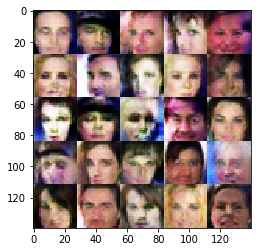

Epoch 1/1:	 Discriminator loss: 1.247	 Generator loss: 0.945
Epoch 1/1:	 Discriminator loss: 1.231	 Generator loss: 0.710
Epoch 1/1:	 Discriminator loss: 1.479	 Generator loss: 0.490
Epoch 1/1:	 Discriminator loss: 1.393	 Generator loss: 0.512
Epoch 1/1:	 Discriminator loss: 1.553	 Generator loss: 0.387
Epoch 1/1:	 Discriminator loss: 1.343	 Generator loss: 0.548
Epoch 1/1:	 Discriminator loss: 1.373	 Generator loss: 0.538
Epoch 1/1:	 Discriminator loss: 1.686	 Generator loss: 0.379
Epoch 1/1:	 Discriminator loss: 1.398	 Generator loss: 0.524
Epoch 1/1:	 Discriminator loss: 1.260	 Generator loss: 0.862


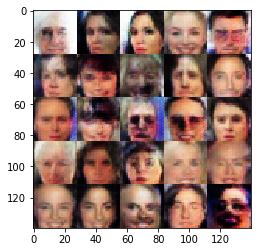

Epoch 1/1:	 Discriminator loss: 1.227	 Generator loss: 0.817
Epoch 1/1:	 Discriminator loss: 1.619	 Generator loss: 0.333
Epoch 1/1:	 Discriminator loss: 1.450	 Generator loss: 0.446
Epoch 1/1:	 Discriminator loss: 1.587	 Generator loss: 0.356
Epoch 1/1:	 Discriminator loss: 1.744	 Generator loss: 0.314
Epoch 1/1:	 Discriminator loss: 1.398	 Generator loss: 0.765
Epoch 1/1:	 Discriminator loss: 1.293	 Generator loss: 0.656
Epoch 1/1:	 Discriminator loss: 1.664	 Generator loss: 0.364
Epoch 1/1:	 Discriminator loss: 1.338	 Generator loss: 1.256
Epoch 1/1:	 Discriminator loss: 1.373	 Generator loss: 0.536


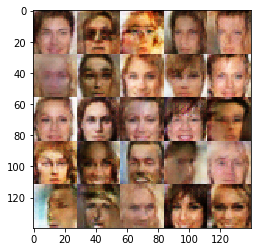

Epoch 1/1:	 Discriminator loss: 1.522	 Generator loss: 0.523
Epoch 1/1:	 Discriminator loss: 1.424	 Generator loss: 0.459
Epoch 1/1:	 Discriminator loss: 1.346	 Generator loss: 0.503
Epoch 1/1:	 Discriminator loss: 1.850	 Generator loss: 0.272
Epoch 1/1:	 Discriminator loss: 1.437	 Generator loss: 0.479
Epoch 1/1:	 Discriminator loss: 1.368	 Generator loss: 0.485
Epoch 1/1:	 Discriminator loss: 1.561	 Generator loss: 0.398
Epoch 1/1:	 Discriminator loss: 1.234	 Generator loss: 0.780
Epoch 1/1:	 Discriminator loss: 1.162	 Generator loss: 0.935
Epoch 1/1:	 Discriminator loss: 1.268	 Generator loss: 0.699


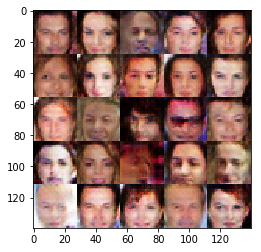

Epoch 1/1:	 Discriminator loss: 1.221	 Generator loss: 0.777
Epoch 1/1:	 Discriminator loss: 1.318	 Generator loss: 0.575
Epoch 1/1:	 Discriminator loss: 1.930	 Generator loss: 0.268
Epoch 1/1:	 Discriminator loss: 1.641	 Generator loss: 0.365
Epoch 1/1:	 Discriminator loss: 1.056	 Generator loss: 1.077
Epoch 1/1:	 Discriminator loss: 1.172	 Generator loss: 0.712
Epoch 1/1:	 Discriminator loss: 1.147	 Generator loss: 0.745
Epoch 1/1:	 Discriminator loss: 1.388	 Generator loss: 0.499
Epoch 1/1:	 Discriminator loss: 1.429	 Generator loss: 0.466
Epoch 1/1:	 Discriminator loss: 1.403	 Generator loss: 0.651


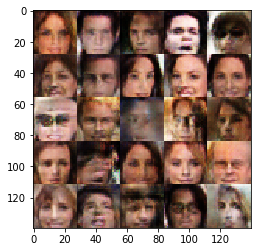

Epoch 1/1:	 Discriminator loss: 1.643	 Generator loss: 0.418
Epoch 1/1:	 Discriminator loss: 1.404	 Generator loss: 0.542
Epoch 1/1:	 Discriminator loss: 1.513	 Generator loss: 0.449
Epoch 1/1:	 Discriminator loss: 1.203	 Generator loss: 0.691
Epoch 1/1:	 Discriminator loss: 1.392	 Generator loss: 0.613
Epoch 1/1:	 Discriminator loss: 1.486	 Generator loss: 0.658
Epoch 1/1:	 Discriminator loss: 1.148	 Generator loss: 0.776
Epoch 1/1:	 Discriminator loss: 1.164	 Generator loss: 1.035
Epoch 1/1:	 Discriminator loss: 1.499	 Generator loss: 0.461
Epoch 1/1:	 Discriminator loss: 1.193	 Generator loss: 0.614


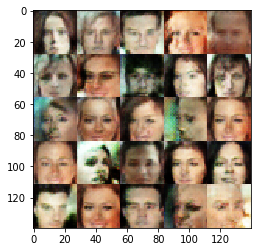

Epoch 1/1:	 Discriminator loss: 1.020	 Generator loss: 0.821
Epoch 1/1:	 Discriminator loss: 1.768	 Generator loss: 0.302
Epoch 1/1:	 Discriminator loss: 1.277	 Generator loss: 0.673
Epoch 1/1:	 Discriminator loss: 1.287	 Generator loss: 0.680
Epoch 1/1:	 Discriminator loss: 1.237	 Generator loss: 0.583
Epoch 1/1:	 Discriminator loss: 1.283	 Generator loss: 0.623
Epoch 1/1:	 Discriminator loss: 1.748	 Generator loss: 0.386
Epoch 1/1:	 Discriminator loss: 1.428	 Generator loss: 0.487
Epoch 1/1:	 Discriminator loss: 1.504	 Generator loss: 0.445
Epoch 1/1:	 Discriminator loss: 1.729	 Generator loss: 0.299


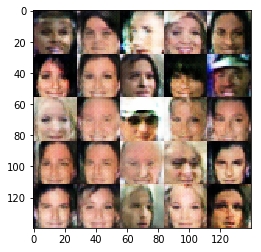

Epoch 1/1:	 Discriminator loss: 2.142	 Generator loss: 0.192
Epoch 1/1:	 Discriminator loss: 1.560	 Generator loss: 0.398
Epoch 1/1:	 Discriminator loss: 1.421	 Generator loss: 0.459
Epoch 1/1:	 Discriminator loss: 1.266	 Generator loss: 0.915
Epoch 1/1:	 Discriminator loss: 1.173	 Generator loss: 0.785
Epoch 1/1:	 Discriminator loss: 1.046	 Generator loss: 0.832
Epoch 1/1:	 Discriminator loss: 1.396	 Generator loss: 0.571
Epoch 1/1:	 Discriminator loss: 1.584	 Generator loss: 0.368
Epoch 1/1:	 Discriminator loss: 1.105	 Generator loss: 1.026
Epoch 1/1:	 Discriminator loss: 1.355	 Generator loss: 0.482


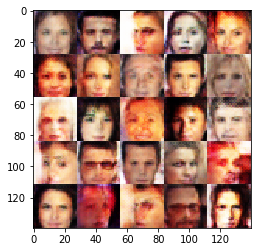

Epoch 1/1:	 Discriminator loss: 1.320	 Generator loss: 0.586
Epoch 1/1:	 Discriminator loss: 1.243	 Generator loss: 0.668
Epoch 1/1:	 Discriminator loss: 1.880	 Generator loss: 0.273
Epoch 1/1:	 Discriminator loss: 1.554	 Generator loss: 0.398
Epoch 1/1:	 Discriminator loss: 1.301	 Generator loss: 0.676
Epoch 1/1:	 Discriminator loss: 1.283	 Generator loss: 0.753
Epoch 1/1:	 Discriminator loss: 1.378	 Generator loss: 0.505
Epoch 1/1:	 Discriminator loss: 1.203	 Generator loss: 0.785
Epoch 1/1:	 Discriminator loss: 1.696	 Generator loss: 0.308
Epoch 1/1:	 Discriminator loss: 1.058	 Generator loss: 1.147


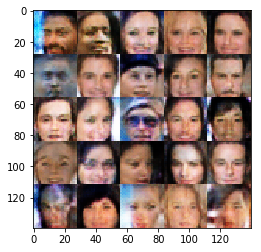

Epoch 1/1:	 Discriminator loss: 1.578	 Generator loss: 0.464
Epoch 1/1:	 Discriminator loss: 1.289	 Generator loss: 0.716
Epoch 1/1:	 Discriminator loss: 1.356	 Generator loss: 0.543
Epoch 1/1:	 Discriminator loss: 1.545	 Generator loss: 0.399
Epoch 1/1:	 Discriminator loss: 1.166	 Generator loss: 0.912
Epoch 1/1:	 Discriminator loss: 1.436	 Generator loss: 0.435
Epoch 1/1:	 Discriminator loss: 1.364	 Generator loss: 0.565
Epoch 1/1:	 Discriminator loss: 1.375	 Generator loss: 0.556
Epoch 1/1:	 Discriminator loss: 1.347	 Generator loss: 0.511
Epoch 1/1:	 Discriminator loss: 1.088	 Generator loss: 0.902


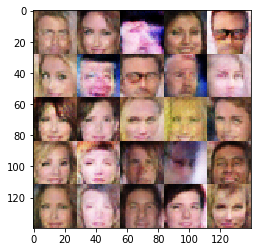

Epoch 1/1:	 Discriminator loss: 1.248	 Generator loss: 0.636
Epoch 1/1:	 Discriminator loss: 1.510	 Generator loss: 0.525
Epoch 1/1:	 Discriminator loss: 1.388	 Generator loss: 0.603
Epoch 1/1:	 Discriminator loss: 1.424	 Generator loss: 0.453
Epoch 1/1:	 Discriminator loss: 1.262	 Generator loss: 0.789
Epoch 1/1:	 Discriminator loss: 1.942	 Generator loss: 0.265
Epoch 1/1:	 Discriminator loss: 1.107	 Generator loss: 0.777
Epoch 1/1:	 Discriminator loss: 1.699	 Generator loss: 0.352
Epoch 1/1:	 Discriminator loss: 1.418	 Generator loss: 0.643
Epoch 1/1:	 Discriminator loss: 1.454	 Generator loss: 0.443


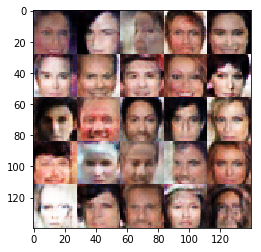

Epoch 1/1:	 Discriminator loss: 1.263	 Generator loss: 0.616
Epoch 1/1:	 Discriminator loss: 1.209	 Generator loss: 0.785
Epoch 1/1:	 Discriminator loss: 1.809	 Generator loss: 0.303
Epoch 1/1:	 Discriminator loss: 1.261	 Generator loss: 0.789
Epoch 1/1:	 Discriminator loss: 1.262	 Generator loss: 0.802
Epoch 1/1:	 Discriminator loss: 1.619	 Generator loss: 0.361
Epoch 1/1:	 Discriminator loss: 1.095	 Generator loss: 1.215
Epoch 1/1:	 Discriminator loss: 1.502	 Generator loss: 0.428
Epoch 1/1:	 Discriminator loss: 1.179	 Generator loss: 0.671
Epoch 1/1:	 Discriminator loss: 1.336	 Generator loss: 0.567


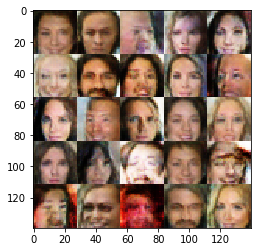

Epoch 1/1:	 Discriminator loss: 1.686	 Generator loss: 0.327
Epoch 1/1:	 Discriminator loss: 1.231	 Generator loss: 0.815
Epoch 1/1:	 Discriminator loss: 1.283	 Generator loss: 0.744


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.